In [1]:
import os
import re
import spacy
import pandas as pd
import logging
from pathlib import Path

# import requirements for converting the dataframe to Spacy Docs
from collections import defaultdict
from unicodedata import normalize
import regex
import random

# Get the root logger
logger = logging.getLogger()

# Remove all handlers from the logger
for handler in logger.handlers[:]:
    logger.removeHandler(handler)

# Add a new handler to the logger
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(name)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

logger.setLevel(logging.DEBUG)

# Define global parameters as lists
INCEPTION_TRAIN_DATA = []
TRAIN_DATA = []
not_found_list = []
MERGED_TRAIN_DATA = []


In [2]:
# config.py

class Config:
    DEFAULT_FORM = 'NFKD'
    REMOVE_ACCENTS = False
    LOWERCASE = False
    STANDARDIZE_APOSTROPHE = True
    REMOVE_BRACKETS = False
    REMOVE_TRAILING_NUMBERS = False
    REMOVE_EXTRA_SPACES = False
    DEBUG = False

# Instantiating the Config class for application-wide access.
app_config = Config()

import re
import unicodedata

# apostrophes and correct_apostrophe are defined as follows:
apostrophes = ["᾽", "᾿", "'", "’", "‘"]
correct_apostrophe = "ʼ"

def clean_and_remove_accents(text: str) -> str:
    """
    Cleans the given text by removing diacritics (accents), except for specific characters,
    and converting it to lowercase.
    """
    allowed_characters = [' ̓', "᾿", "᾽", "'", "’", "‘", 'ʼ', '̓']  # Including the Greek apostrophe
    if not isinstance(text, str):
        raise ValueError("Input must be a string.")
    try:
        non_accent_chars = [c for c in unicodedata.normalize('NFKD', text) 
        if unicodedata.category(c) != 'Mn' or c in allowed_characters]
        return ''.join(non_accent_chars)
    
    except Exception as e:
        # A more generic exception handling if unexpected errors occur
        print(f"An error occurred: {e}")
        return text
    

def normalize_text(text: str, 
                   form: str = None, 
                   remove_accents: bool = None, 
                   lowercase: bool = None, 
                   standardize_apostrophe: bool = None, 
                   remove_brackets: bool = None, 
                   remove_trailing_numbers: bool = None, 
                   remove_extra_spaces: bool = None, 
                   debug: bool = None) -> str:
    """
    Applies multiple text normalization and cleaning steps on the input text.

    Parameters:
    - text (str): The text to be normalized.
    - form (str): Unicode normalization form ('NFC', 'NFD', 'NFKC', 'NFKD').
    - remove_accents (bool): If True, removes accents from the text.
    - lowercase (bool): If True, the text is converted to lowercase.
    - standardize_apostrophe (bool): If True, replaces all defined apostrophe characters with a standard one.
    - remove_brackets_only (bool): If True, removes the brackets themselves.
    - remove_trailing_numbers (bool): If True, strips leading or trailing digits from the text.
    - remove_extra_spaces (bool): If True, removes extra spaces and leading/trailing spaces.
    - debug (bool): If True, prints before and after states for each operation.
    
    Returns:
    - str: The processed text.
    """
    
    # Fetch default settings from app_config if not provided
    form = form if form is not None else app_config.DEFAULT_FORM
    remove_accents = remove_accents if remove_accents is not None else app_config.REMOVE_ACCENTS
    lowercase = lowercase if lowercase is not None else app_config.LOWERCASE
    standardize_apostrophe = standardize_apostrophe if standardize_apostrophe is not None else app_config.STANDARDIZE_APOSTROPHE
    remove_brackets = remove_brackets if remove_brackets is not None else app_config.REMOVE_BRACKETS
    remove_trailing_numbers = remove_trailing_numbers if remove_trailing_numbers is not None else app_config.REMOVE_TRAILING_NUMBERS
    remove_extra_spaces = remove_extra_spaces if remove_extra_spaces is not None else app_config.REMOVE_EXTRA_SPACES
    debug = debug if debug is not None else app_config.DEBUG
    
    normalized_text = text  # Initialize normalized_text with the original text

    # Function to print before and after states for each operation during debugging
    def debug_print(operation_name, before, after):
        if debug:
            logger.debug(f"{operation_name} - Before: {before}")
            logger.debug(f"{operation_name} - After: {after}")

    # Standardize apostrophe characters if required
    if standardize_apostrophe:
        before_text = normalized_text
        for apos in apostrophes:
            normalized_text = normalized_text.replace(apos, correct_apostrophe)
        debug_print("Standardizing apostrophes", before_text, normalized_text)
        
    if remove_accents:
        before_text = normalized_text
        try:
            normalized_text = clean_and_remove_accents(normalized_text)
        except Exception as e:
            logger.error(f"An error occurred while removing accents: {e}")
            # Decide what to do here: return the original text, a special value, or stop the process
            return text        
        debug_print("Removing accents", before_text, normalized_text)
        
    # Convert to lowercase if required
    if lowercase:
        before_text = normalized_text
        normalized_text = normalized_text.lower()
        debug_print("Lowercase conversion", before_text, normalized_text)

    # Unicode normalization
    if form:
        before_text = normalized_text
        normalized_text = unicodedata.normalize(form, normalized_text)
        debug_print("Unicode normalization", before_text, normalized_text)
            
    # Remove brackets only if required
    if remove_brackets:
        before_text = normalized_text
        normalized_text = re.sub(r'[\(\)\[\]]', '', normalized_text)
        debug_print("Removing brackets", before_text, normalized_text)
        
    # Remove trailing numbers if required
    if remove_trailing_numbers:
        before_text = normalized_text
        normalized_text = re.sub(r'^\d+|\d+$', '', normalized_text)
        debug_print("Removing trailing numbers", before_text, normalized_text)

    # Remove multiple spaces and leading/trailing spaces
    if remove_extra_spaces:
        before_text = normalized_text
        normalized_text = ' '.join(normalized_text.split()).strip()
        debug_print("Removing extra spaces", before_text, normalized_text)

    return normalized_text

# Load and process data from Coda

In [3]:

# Load the dataset
FILE_PATH = "../assets/NER_assets/Ancient_Words_12_5_22.csv"
df = pd.read_csv(FILE_PATH)

# Renaming columns
df.rename(columns={'Word': 'Keyword', 'Category Types': 'Label'}, inplace=True)

# Filling NaN values more efficiently and appropriately
for early_col, new_col in [('Early Quote', 'Quote'), ('Early Word Before', 'Word Before'), 
                           ('Early Word After', 'Word After'), ('Early Category Type', 'Label')]:
    df[new_col].fillna(df[early_col], inplace=True)

# Dropping rows with no Keyword and non-Greek Keywords
pat = '[ء-ي]+'
df = df.dropna(subset=['Keyword']).copy()
df = df[~df['Keyword'].str.contains(pat, na=False)]

# Cleaning data with combined regex patterns

# Define a dictionary of patterns and replacements for the entire dataframe
df_replacements = {
    '\d+': '',  # Numbers
    '-': '',  # Hyphens
    ' +': ' ',  # Multiple spaces
}

# Apply the replacements to the text columns ('Early Quote', 'Quote', 'Early Word Before', 'Word Before', 'Early Word After', 'Word After', 'Keyword')
for col in ['Early Quote', 'Quote', 'Early Word Before', 'Word Before', 'Early Word After', 'Word After', 'Keyword']:
    for pattern, replacement in df_replacements.items():
        df[col].replace(pattern, replacement, regex=True, inplace=True)

# Define a dictionary of patterns and replacements for the 'Keyword' column
keyword_replacements = {
    '\n': '',  # New line
    ',': '',  # Comma
    '\.': '',  # Period
    '\·': '',  # Interpunkt
    '\s+$': ''  # End punctuation
}

# Apply the replacements to the 'Keyword' column
for pattern, replacement in keyword_replacements.items():
    df['Keyword'].replace(pattern, replacement, regex=True, inplace=True)
# Resetting the dataframe index
df.reset_index(drop=True, inplace=True)

# Normalizing the text in the columns
columns_to_normalize = ['Early Quote', 'Quote', 'Early Word Before', 'Word Before', 'Early Word After', 'Word After', 'Keyword']

for col in columns_to_normalize:
    if df[col].dtype == 'object':
        df[col] = df[col].apply(lambda x: normalize_text(x) if pd.notna(x) else x)

In [4]:
len(df)

1411

In [5]:
def create_source_description(row):
    formatted_values = []
    for col in ['Modern Edition', 'Book', 'Chapter', 'Section', 'Page', 'Line Number']:
        value = row[col]
        if pd.notna(value) and value != '':
            # Handling special case for Modern Edition
            formatted_value = str(value) if col == 'Modern Edition' else f"{col[0]}({int(value)})" if isinstance(value, (int, float)) else f"{col[0]}({value})"
            formatted_values.append(formatted_value)
    source = ', '.join(formatted_values)
    return f"Coda, {source}"

df['Source'] = df.apply(create_source_description, axis=1)

## Fix similar sentences

In [6]:
def ngrams(sentence, n=2):
    """Returns a list of n-grams from the sentence."""
    # Convert sentence to lowercase and split into tokens/words
    tokens = sentence.lower().split()
    # Generate n-grams
    return set(zip(*[tokens[i:] for i in range(n)]))

def jaccard_similarity(set1, set2):

    debug = app_config.DEBUG

    """Calculate the Jaccard Similarity between two sets, handling empty sets."""
    try:
        intersection = len(set1.intersection(set2))
        print(f"Intersection: {intersection}") if debug else None
        
        union = len(set1.union(set2))
        print(f"Union: {union}") if debug else None
        
        return intersection / union if union != 0 else 0
    except Exception as e:
        print(f"An error occurred: {e}") if debug else None
        return None

# Assuming df_grouped is your DataFrame and 'Quote' is the column with sentences.
threshold = 0.5  # Example threshold, adjust based on your requirements
groups = []
df_grouped = df.copy()
df_grouped["Quote_ngrams"] = df_grouped["Quote"].apply(lambda x: ngrams(x, n=2)) # Create n-grams for each quote

for i, base_row in df_grouped.iterrows():
    similar_found = False
    base_ngrams = base_row["Quote_ngrams"]
    
    for group in groups:
        representative_index = group[0]  # Use the first sentence of each group as the representative
        representative_ngrams = df_grouped.loc[representative_index, "Quote_ngrams"]
        
        if jaccard_similarity(base_ngrams, representative_ngrams) >= threshold:
            group.append(i)
            similar_found = True
            break
            
    if not similar_found:
        groups.append([i])  # Start a new group
        
from collections import Counter

# Initialize a list to hold the data for the new DataFrame
new_data = []

for group_indices in groups:
    # Extract sentences and their corresponding rows for the current group
    group_rows = df_grouped.iloc[group_indices]
    
    # Determine the most frequent sentence in the group
    sentence_counts = Counter(group_rows['Quote'])
    most_freq_sentence, _ = sentence_counts.most_common(1)[0]
    
    # Determine the most complete (longest) sentence in the group after removing whitespace
    most_complete_sentence = group_rows.loc[group_rows['Quote'].str.len().idxmax(), 'Quote']
    
    # Choose the sentence to use based on frequency and completeness
    sentence_to_use = most_freq_sentence if len(most_freq_sentence) >= len(most_complete_sentence) else most_complete_sentence
    
    # Consolidate labels, keywords, words before, and words after into lists
    entities = group_rows[['Label', 'Keyword', 'Word Before', 'Word After']].values.tolist()
    
    source_detail = group_rows.loc[group_rows['Quote'].str.len().idxmax(), 'Source']  # Use source of most complete sentence
    
    # Append to new data list: the chosen sentence, the consolidated entities and the source
    new_data.append({'Quote': sentence_to_use, 'Entities': entities, 'Source': source_detail})

# Create a new DataFrame from the new data
df_final = pd.DataFrame(new_data)

# Print the groups, their sentences with their original index, and the chosen sentence for verification
for i, group_indices in enumerate(groups):
    print(f"Group {i + 1}:")
    for index in group_indices:
        print(f"  - Index {index}: {df_grouped.loc[index, 'Quote']}, Source: {df_grouped.loc[index, 'Source']}")
    print(f"  Chosen sentence: {df_final.loc[i, 'Quote']}, Source: {df_final.loc[i, 'Source']}\n")
    print(f"  Entities: {df_final.loc[i, 'Entities']}\n")
        
# Structure of df_final:
# 'Quote': The representative sentence of the group.
# 'Entities': A list of lists for each sentence, containing label, keyword, word before, and word after.

Group 1:
  - Index 0: ἐν ἑκάστῃ γὰρ ἔχει αἷμα τῶν κοιλιῶν, λεπτότατον δʼ ἐστὶ τὸ ἐν τῇ μέσῃ, Source: Coda, Aristotle, History of Animals, B(1), C(17), P(84), L(9)
  - Index 288: ἐν ἑκάστῃ γὰρ ἔχει αἷμα τῶν κοιλιῶν, λεπτότατον δʼ ἐστὶ τὸ ἐν τῇ μέσῃ, Source: Coda, Aristotle, History of Animals, B(1), C(17), P(84), L(9)
  - Index 295: ἐν ἑκάστῃ γὰρ ἔχει αἷμα τῶν κοιλιῶν, λεπτότατον δʼ ἐστὶ τὸ ἐν τῇ μέσῃ, Source: Coda, Aristotle, History of Animals, B(1), C(17), P(84), L(10)
  - Index 296: ἐν ἑκάστῃ γὰρ ἔχει αἷμα τῶν κοιλιῶν, λεπτότατον δʼ ἐστὶ τὸ ἐν τῇ μέσῃ, Source: Coda, Aristotle, History of Animals, B(1), C(17), P(84), L(10)
  - Index 304: ἐν ἑκάστῃ γὰρ ἔχει αἷμα τῶν κοιλιῶν, λεπτότατον δʼ ἐστὶ τὸ ἐν τῇ μέσῃ, Source: Coda, Aristotle, History of Animals, B(1), C(17), P(84), L(9)
  - Index 305: ἐν ἑκάστῃ γὰρ ἔχει αἷμα τῶν κοιλιῶν, λεπτότατον δʼ ἐστὶ τὸ ἐν τῇ μέσῃ, Sourc

In [7]:
# check the first 5 rows of the dataframe
df_final

,Quote,Entities,Source
0,ἐν ἑκάστῃ γὰρ ἔχει αἷμα τῶν κοιλιῶν...,"[[Body Part, αἷμα, γὰρ ἔχει, τῶν κοιλιῶ...","Coda, Aristotle, History of Animals, B(1), C(1..."
1,Ὑπὸ δὲ τὸν πνεύμονά ἐστι τὸ διάζωμα τ...,"[[Topography, Ὑπὸ, μέσῃ., δὲ τὸν], [Body...","Coda, Aristotle, History of Animals, B(1), C(1..."
2,Ἔχει δὲ διʼ αὑτοῦ καὶ φλέβας τεταμένας,"[[Topography, διʼ, Ἔχει δὲ, αὑτοῦ καὶ], ...","Coda, Aristotle, History of Animals, B(1), C(1..."
3,εἰσὶ δʼαἱ τοῦ ἀνθρώπου φρένες παχεῖαι ...,"[[Body Part, φρένες, ἀνθρώπου, παχεῖαι], [...","Coda, Aristotle, History of Animals, B(1), C(1..."
4,Ἡ μὲν οὖν ἀρτηρία τοῦτον ἔχει τὸν τρ...,"[[Body Part, ἀρτηρία, οὖν, τοῦτον], [Path...","Coda, Aristotle, History of Animals, B(1), C(1..."
...,...,...,...
209,ἐξ ἅπαντος γὰρ τοῦ σώματος φλέβες ἐς α...,"[[Body Part, φλέβες, σώματος, ἐς], [Adjecti...","Coda, Hippocrates, Sacred Disease, C(17), S(3)..."
210,ἀνάγκη γὰρ καὶ ἀνιώμενον φρίσσειν τε το...,"[[Topography, συντείνεσθαι, καὶ , καὶ ]]","Coda, Hippocrates, Sacred Disease, C(17), S(3)..."
211,διότι ἡ καρδίη αἰσθάνεταί τε μάλιστα κα...,"[[Body Part, καρδίη, ἡ , αἰσθάνεταί ], [B...","Coda, Hippocrates, Sacred Disease, C(17), S(3)..."
212,"Τῆς μέντοι φρονήσιος οὐδετέρῳ μέτεστιν,...","[[Body Part, ἐγκέφαλος, αἴτιός ὁ, ἐστιν.]]","Coda, Hippocrates, Sacred Disease, C(17), S(3)..."


## Fix similar words

In [8]:
import regex as re
import unicodedata


def build_exact_pattern(word):
    """
    Builds a regex pattern that matches the word exactly, including diacritics.
    """
    return re.escape(word)

def build_diacritic_agnostic_pattern(word, form=None, debug=None, max_errors=2, debug_patterns=None):
    """
    Builds a regex pattern that matches the word in a diacritic-agnostic manner.
    """
    # Apply normalization as per configurations or provided form
    form = form if form is not None else app_config.DEFAULT_FORM
    debug = debug if debug is not None else app_config.DEBUG

    if not word:
        return None  # Return None for empty strings

    decomposed_word = unicodedata.normalize(form, word)
    pattern_parts = []
    for char in decomposed_word:
        if unicodedata.category(char) == 'Mn':  # Is a diacritic mark
            # This character is a diacritic; make its presence optional in the pattern
            pattern_parts.append(r'\p{M}*')  # Make diacritics optional
        else:
            # For non-diacritic characters, escape them and option
            pattern_parts.append(re.escape(char) + r'\p{M}*')  # Escape non-diacritics and allow diacritics

    pattern = ''.join(pattern_parts)
    logger.debug(f"Regex Pattern: {pattern}") if debug and debug_patterns else None

    # Construct the fuzzy pattern separately
    fuzzy_pattern = rf"(?:{pattern})"
    if max_errors > 0:
        fuzzy_pattern += rf"{{s<={max_errors}}}"

    logger.debug(f"word: {word}, fuzzy_pattern: {fuzzy_pattern}")  if debug and debug_patterns else None # Debug print

    return fuzzy_pattern

def find_word_index(sentence, word, word_before, word_after, form=None, debug=None, debug_patterns=None, max_errors=2, **kwargs):
    """
    Finds the index of a word within a sentence, allowing for various normalization options and
    tolerating diacritic variations and minor errors.
    Raises a ValueError if the word is not found in the sentence.
    """
    debug = debug if debug is not None else app_config.DEBUG

    form = form if form is not None else app_config.DEFAULT_FORM

    # Override/debug settings are explicitly set here
    kwargs['remove_accents'] = False
    kwargs['lowercase'] = True  
    kwargs['remove_extra_spaces'] = True
    kwargs["remove_brackets"] = False
    kwargs["form"] = form

    if not sentence or not word:
        raise ValueError("Sentence and word must be provided")

    # Normalize inputs
    try:
        normalized_sentence = normalize_text(sentence, **{**app_config.__dict__, **kwargs})
        normalized_word = normalize_text(word, **{**app_config.__dict__, **kwargs})
        normalized_word_before = normalize_text(word_before, **{**app_config.__dict__, **kwargs}) if word_before else ""
        normalized_word_after = normalize_text(word_after, **{**app_config.__dict__, **kwargs}) if word_after else ""
    except Exception as e:
        logger.error(f"Error normalizing inputs: {e}")
        raise ValueError(f"Could not normalize inputs: sentence={sentence}, word={word}, word_before={word_before}, word_after={word_after}")

    logger.debug(f"Input: sentence={sentence}, \n word={word}, word_before={word_before}, word_after={word_after}, form={form}, kwargs={kwargs}") if debug and debug_patterns else None
    logger.debug(f"Normalized sentence: {normalized_sentence}") if debug and debug_patterns else None
    logger.debug("normalized_word: %s, normalized_word_before: %s, normalized_word_after: %s", normalized_word, normalized_word_before, normalized_word_after) if debug and debug_patterns else None
    # Build exact and diacritic-agnostic patterns
    try:
        #exact_word_pattern = build_exact_pattern(normalized_word)
        #word_pattern = build_diacritic_agnostic_pattern(normalized_word, form=form, debug=debug, max_errors=max_errors)
        #exact_word_before_pattern = build_exact_pattern(normalized_word_before)
        #word_before_pattern = build_diacritic_agnostic_pattern(normalized_word_before, form=form, debug=debug, max_errors=max_errors)
        #exact_word_after_pattern = build_exact_pattern(normalized_word_after) if word_after else None
        #word_after_pattern = build_diacritic_agnostic_pattern(normalized_word_after, form=form, debug=debug, max_errors=max_errors)
        exact_word_pattern = build_exact_pattern(normalized_word)
        word_pattern = build_diacritic_agnostic_pattern(normalized_word, form=form, debug=debug, max_errors=max_errors)
        
        exact_word_before_pattern = build_exact_pattern(normalized_word_before) if normalized_word_before else None
        word_before_pattern = build_diacritic_agnostic_pattern(normalized_word_before, form=form, debug=debug, max_errors=max_errors) if normalized_word_before else None

        exact_word_after_pattern = build_exact_pattern(normalized_word_after) if normalized_word_after else None
        word_after_pattern = build_diacritic_agnostic_pattern(normalized_word_after, form=form, debug=debug, max_errors=max_errors) if normalized_word_after else None
        
        logger.debug(f"exact_word_pattern: {exact_word_pattern}") if debug and debug_patterns else None
        logger.debug(f"exact_word_before_pattern: {exact_word_before_pattern}") if debug else None
        logger.debug(f"exact_word_after_pattern: {exact_word_after_pattern}") if debug else None
        logger.debug(f"word_pattern: {word_pattern}") if debug and debug_patterns else None
        logger.debug(f"word_before_pattern: {word_before_pattern}") if debug else None
        logger.debug(f"word_after_pattern: {word_after_pattern}") if debug else None

    except Exception as e:
        logger.error(f"Error building patterns: {e}")
        raise ValueError(f"Could not build patterns for: word={word}, word_before={word_before}, word_after={word_after}")

    
    #patterns = create_patterns(sentence, exact_word_pattern=exact_word_pattern, exact_word_before_pattern=exact_word_before_pattern, exact_word_after_pattern=exact_word_after_pattern, word_before=word_before, word_after=word_after, max_errors=max_errors, debug=debug, debug_patterns=debug_patterns)
    patterns = create_patterns(sentence, exact_word_pattern=exact_word_pattern,
                            word_before=word_before, word_after=word_after, 
                            exact_word_before_pattern=exact_word_before_pattern, exact_word_after_pattern=exact_word_after_pattern)
    for pattern in patterns.values():
        logger.debug(f"Attempting with pattern: {pattern}") if debug and debug_patterns else None
        try:
            matches = re.finditer(pattern, normalized_sentence)
            for match in matches:
                match_word = match.group(1).rstrip()
                start, end = match.start(1), match.start(1) + len(match_word)
                return start, end, normalized_sentence
        except Exception as e:
            logger.debug(f"Word '{word}' not found in sentence '{sentence}'")

    #patterns = create_patterns(sentence, exact_word_pattern=exact_word_pattern, exact_word_before_pattern=exact_word_before_pattern, exact_word_after_pattern=exact_word_after_pattern, word_before=word_before, word_after=word_after, max_errors=max_errors, debug=debug, debug_patterns=debug_patterns)
    patterns = create_patterns(sentence=sentence, word_pattern=word_pattern, 
                           word_before=word_before, word_after=word_after, word_before_pattern=word_before_pattern, 
                           word_after_pattern=word_after_pattern)
    for pattern in patterns.values():
        logger.debug(f"Attempting with pattern: {pattern}") if debug and debug_patterns else None
        try:
            matches = re.finditer(pattern, normalized_sentence)
            for match in matches:
                match_word = match.group(1).rstrip()
                start, end = match.start(1), match.start(1) + len(match_word)
                return start, end, normalized_sentence
        except Exception as e:
            logger.debug(f"Word '{word}' not found in sentence '{sentence}'")

def create_patterns(sentence, exact_word_pattern=None, word_pattern=None, word_before=None, word_after=None, word_before_pattern=None, word_after_pattern=None, exact_word_before_pattern=None, exact_word_after_pattern=None, max_errors=2, debug=False, debug_patterns=False):
    patterns = {}
    optional_punct_pattern = r"[,;.!?]?\s*"  # Pattern for optional punctuation followed by optional whitespace

    logger.debug(f"exact_word_pattern: {exact_word_pattern}, word_pattern: {word_pattern}, word_before: {word_before}, word_after: {word_after}, word_before_pattern: {word_before_pattern}, word_after_pattern: {word_after_pattern}, exact_word_before_pattern: {exact_word_before_pattern}, exact_word_after_pattern: {exact_word_after_pattern}") if debug and debug_patterns else None
    
    # First, try to match the exact word pattern along with the exact word before and after patterns
    if exact_word_before_pattern and exact_word_after_pattern:
        logger.debug(f"THE WORD BEFORE PATTERN IS: {word_before_pattern}")
        logger.debug(f"THE WORD AFTER PATTERN IS: {word_after_pattern}")
        logger.debug(f"THE EXACT WORD BEFORE PATTERN IS: {exact_word_before_pattern}")
        logger.debug(f"THE EXACT WORD AFTER PATTERN IS: {exact_word_after_pattern}")
        #patterns['both_exact_before_and_after_pattern'] = rf"(?:(?<!\p{{L}}){exact_word_before_pattern}\s*{optional_punct_pattern})({exact_word_pattern}|{word_pattern})(?:{optional_punct_pattern}{exact_word_after_pattern}(?!\p{{L}}))"
        patterns['both_exact_before_and_after_pattern'] = rf"(?<={exact_word_before_pattern}\s*{optional_punct_pattern})({exact_word_pattern}|{word_pattern})(?=\s*{optional_punct_pattern}{exact_word_after_pattern})"
        logger.debug(f"exact_word_before_pattern in both_before_and_after: {exact_word_before_pattern}") if debug and debug_patterns else None
        logger.debug(f"exact_word_after_pattern in both_before_and_after: {exact_word_after_pattern}") if debug and debug_patterns else None
        logger.debug(f"both_before_and_after pattern: {patterns['both_exact_before_and_after_pattern']}") if debug and debug_patterns else None

    # When both before and after patterns are specified
    if word_before_pattern and word_after_pattern:
        #patterns['both_before_and_after'] = rf"(?<=(?<!\p{{L}}){word_before_pattern}\s*{optional_punct_pattern})({exact_word_pattern}|{word_pattern})(?:{optional_punct_pattern}{word_after_pattern}(?!\p{{L}}))"
        patterns['both_before_and_after'] = rf"(?<={word_before_pattern}\s*{optional_punct_pattern})({exact_word_pattern}|{word_pattern})(?=\s*{optional_punct_pattern}{word_after_pattern})"
        logger.debug(f"both_before_and_after pattern: {patterns['both_before_and_after']}") if debug and debug_patterns else None

    # When only the before pattern is specified and it's not a single non-word character
    logger.debug(f"THE WORD PATTERN IS: {word_pattern}")
    logger.debug(f"THE WORD BEFORE PATTERN IS: {word_before_pattern}")
    logger.debug(f"THE WORD AFTER PATTERN IS: {word_after_pattern}")
    logger.debug(f"THE EXACT WORD BEFORE PATTERN IS: {exact_word_before_pattern}")
    logger.debug(f"THE EXACT WORD AFTER PATTERN IS: {exact_word_after_pattern}")
    logger.debug("CHECKKKKKEKE %s %s %s", word_before_pattern, word_before, len(word_before)) if debug and debug_patterns and word_before else None
    #if any([exact_word_before_pattern, word_before_pattern]) and len(word_before) > 1:
    if word_before is not None and len(word_before.strip()) > 0:
        logger.debug("found word before!!! WooHOO!") if debug and debug_patterns else None
        #patterns['only_before'] = rf"(?<=(?<!\p{{L}}){exact_word_before_pattern}|{word_before_pattern}\s*{optional_punct_pattern})({exact_word_pattern}|{word_pattern})(?!\p{{L}})"
        patterns['only_before'] = rf"(?<={exact_word_before_pattern or ''}\s*{optional_punct_pattern})({exact_word_pattern}|{word_pattern})"
        logger.debug(f"only_before pattern: {patterns['only_before']}") if debug and debug_patterns else None
    
    # when only the after pattern is specified and it's not a single non-word character
    logger.debug(f"Checking word before : {word_before_pattern}, {word_before}") if debug and debug_patterns else None
    logger.debug(f"Checking word after : {word_after_pattern}, {word_after}") if debug and debug_patterns else None
    #if any([exact_word_after_pattern, word_after_pattern]) and len(word_after) > 1:
    if word_after is not None and len(word_after.strip()) > 0:
        #patterns['only_after'] = rf"({exact_word_pattern}|{word_pattern})(?:{optional_punct_pattern}{exact_word_after_pattern}|{word_after_pattern}(?!\p{{L}}))"
        patterns['only_after'] = rf"({exact_word_pattern}|{word_pattern})(?=\s*{optional_punct_pattern}{exact_word_after_pattern})"
        logger.debug(f"only_after pattern: {patterns['only_after']}") if debug and debug_patterns else None

    # When the before pattern is a single non-word character or None
    if any([exact_word_before_pattern, word_before_pattern]) and (word_before is None or len(word_before) <= 1):
        patterns['before_single_or_empty'] = rf"(?<=(?<!\p{{L}}){exact_word_before_pattern}|{word_before_pattern}\s*{optional_punct_pattern})({exact_word_pattern}|{word_pattern})(?!\p{{L}})"
        logger.debug(f"before_single_or_empty pattern: {patterns['before_single_or_empty']}") if debug and debug_patterns else None
        
    # When the after pattern is a single non-word character or None
    if any([exact_word_after_pattern, word_after_pattern]) and (word_after is None or len(word_after) <= 1):
        patterns['after_single_or_empty'] = rf"({exact_word_pattern}|{word_pattern})(?:(?={optional_punct_pattern}{exact_word_after_pattern}|{word_after_pattern})|$)(?!\p{{L}})"
        logger.debug(f"after_single_or_empty pattern: {patterns['after_single_or_empty']}") if debug and debug_patterns else None

    # Word at the start of the sentence (no preceding word boundary)
    patterns['start_of_sentence'] = rf"^({exact_word_pattern}|{word_pattern})(?=\s|\p{{P}}|$)"
    logger.debug(f"start_of_sentence pattern: {patterns['start_of_sentence']}") if debug and debug_patterns else None

    # Word at the end of the sentence (no following word boundary)
    #patterns['end_of_sentence'] = rf"(?<=^|\s|\p{{P}})({exact_word_pattern}|{word_pattern}){optional_punct_pattern}?$"
    patterns['end_of_sentence'] = rf"(?<=^|\s|\p{{P}})({exact_word_pattern}|{word_pattern})[{optional_punct_pattern}]?$"

    logger.debug(f"end_of_sentence pattern: {patterns['end_of_sentence']}") if debug and debug_patterns else None

    # Word anywhere in the sentence, not accounting for specific before/after context
    #patterns['anywhere_in_sentence'] = rf"(?<!\p{{L}})({exact_word_pattern}|{word_pattern})(?!\p{{L}})"
    #print(f"anywhere_in_sentence pattern: {patterns['anywhere_in_sentence']}") if debug and debug_patterns else None


    # Debugging code
    if debug and debug_patterns:
        # Check if 'both_before_and_after' pattern exists and print it
        if 'both_before_and_after' in patterns:
            logger.debug(f"both_before_and_after pattern: {patterns['both_before_and_after']}")
            logger.debug(f"both_before_and_after pattern matches sentence: {bool(re.search(patterns['both_before_and_after'], sentence))}")

        # Check if "exact_word_before_pattern" exists and print it
        if exact_word_before_pattern:
            logger.debug(f"exact_word_before_pattern: {exact_word_before_pattern}")
            logger.debug(f"exact_word_before_pattern matches sentence: {bool(re.search(exact_word_before_pattern, sentence))}")
            
        # Check if 'word_before_pattern' exists and print it
        if word_before_pattern:
            logger.debug(f"word_before_pattern: {word_before_pattern}")
            logger.debug(f"word_before_pattern matches sentence: {bool(re.search(word_before_pattern, sentence))}")

        # Check if "exact_word_after_pattern" exists and print it
        if exact_word_after_pattern:
            logger.debug(f"exact_word_after_pattern: {exact_word_after_pattern}")
            logger.debug(f"exact_word_after_pattern matches sentence: {bool(re.search(exact_word_after_pattern, sentence))}")
            
        # Check if 'word_after_pattern' exists and print it
        if word_after_pattern:
            logger.debug(f"word_after_pattern: {word_after_pattern}")
            logger.debug(f"word_after_pattern matches sentence: {bool(re.search(word_after_pattern, sentence))}")

    return patterns


In [9]:
def prepare_training_data(df, form=None, debug=None, debug_patterns=None, debug_inception=None, **kwargs):
    """
    Prepares the training data by finding entity indices within normalized sentences.
    Returns a list of training data and a list of words not found in their sentences.
    """
    # Apply normalization as per configurations or provided form
    debug = debug if debug is not None else app_config.DEBUG
    
    # Ensuring 'remove_accents' and 'lowercase' have fixed values for this function's purpose
    kwargs['remove_accents'] = False
    kwargs['lowercase'] = True  # Override/debug settings are explicitly set here
    kwargs['remove_extra_spaces'] = True
    kwargs["remove_brackets"] = False
    kwargs["form"] = form
    logger.debug("kwargs: ", kwargs) if debug else None

    TRAIN_DATA = []
    not_found_list = []
    found_entities = 0

    for i, (_, row) in enumerate(df.iterrows(), start=1):
        new_entities = []
        sentence = row['Quote']
        source = row['Source']
        logger.debug(f"Sentence {i}: {sentence}, Source: {source}") if debug else None
        for entity in row['Entities']:
            logger.debug (f"Entity: {entity}") if debug else None
            try:
                category, word, word_before, word_after = entity
                logger.debug(f"Category: {category}, Word: {word}, Word Before: {word_before}, Word After: {word_after}") if debug else None
                start, end, _ = find_word_index(sentence, word, word_before, word_after, **{**app_config.__dict__, **kwargs}, debug=debug)
                new_entities.append((start, end, category))
                found_entities += 1
            except Exception as e:
                logger.error(f"Error finding word index for entity {entity}: {e}")
                not_found_list.append((word, sentence))
        
        logger.debug(f"Found {len(new_entities)} entities in this sentence.") if debug else None
        normalized_sentence = normalize_text(sentence, **{**app_config.__dict__, **kwargs})
        TRAIN_DATA.append((normalized_sentence, {'entities': new_entities}, source))

    logger.info(f"Completed preparing training data from table. Total entries: {len(TRAIN_DATA)}. Entities found and registered: {found_entities}. Entities not found: {len(not_found_list)}")
    return TRAIN_DATA, not_found_list

In [18]:
Dataa = []
new_entities = []
#[['Body Part', 'γένειον', 'τὸ πρόσθιον', ', τὸ δʼ'], ['Body Part', 'γένυς', 'δʼ ὀπίσθιον', '. Κινεῖ δὲ'], ['Adjectives/Qualities', 'πρόσθιον', 'τούτων τὸ', 'γένειον, τὸ'], ['Adjectives/Qualities', 'ὀπίσθιον', 'τὸ δʼ', 'γένυς. Κινεῖ'], ['Division', 'τὸ', 'δύο· τούτων', 'πρόσθιον γένειον'], ['Division', 'τὸ', 'πρόσθιον γένειον,', 'δʼ ὀπίσθιον']]
#'Division', 'τὸ', 'δύο· τούτων', 'πρόσθιον γένειον'], ['Division', 'τὸ', 'πρόσθιον γένειον,', 'δʼ ὀπίσθιον']]
#sentence="τούτων τὸ πρόσθιον γένειον, τὸ δʼ ὀπίσθιον γένυς"
#word='τὸ'
#word_before='δύο· τούτων'
#word_after='πρόσθιον γένειον'

#word='τὸ'
#word_before='πρόσθιον γένειον,'
#word_after='δʼ ὀπίσθιον'

#sentence="ἐνίοις μὲν γὰρ εὐρύτερον τὸ πρὸς τῇ κοιλίᾳ, τὸ δὲ πρὸς τῷ τέλει στενώτερον (διόπερ αἱ κύνες μετὰ πόνου προΐενται τὴν τοιαύτην περίττωσιν), τοῖς δὲ πλείοσιν ἄνωθεν στενώτερον, πρὸς τῷ τέλει δ' εὐρύτερον"
#word='εὐρύτερον'
#word_before="τέλει δ'"
#word_after='. Μείζω δὲ'

#sentence = "ἐν ἑκάστῃ γὰρ ἔχει αἷμα τῶν κοιλιῶν, λεπτότατον δʼ ἐστὶ τὸ ἐν τῇ μέσῃ."
#word = "μέσῃ"
#word_before = "τῇ "
#word_after = ". ὑπό"

#sentence = "Ἔστι δʼ οὐ πολυσχιδὴς ὁ τοῦ ἀνθρώπου, ὥσπερ ἐνίων ζῳοτόκων, οὐδὲ λεῖος, ἀλλʼ ἔχει ἀνωμαλίαν"
#word = "ζῳοτόκων"
#word_before = "ὥσπερ ἐνίων"
#word_after = " οὐδὲ λεῖος"

#sentence = "ἐν ἑκάστῃ γὰρ ἔχει αἷμα τῶν κοιλιῶν, λεπτότατον δʼ ἐστὶ τὸ ἐν τῇ μέσῃ"
#word = "ἑκάστῃ"
#word_before = "αὑτῇ· ἐν"
#word_after = "γὰρ ἔχει"

#sentence = "Ὑπὸ δὲ τὸν πνεύμονά ἐστι τὸ διάζωμα τὸ τοῦ θώρακος, αἱ καλούμεναι φρένες, πρὸς μὲν τὰ πλευρὰ καὶ τὰ ὑποχόνδρια καὶ τὴν ῥάχιν συνηρτημέναι, ἐν μέσῳ δʼ ἔχει τὰ λεπτὰ καὶ ὑμενώδη"
#word = "πνεύμονα"
#word_before = "δὲ τὸν"
#word_after = "ἐστι τὸ"

#sentence = "Ὑπὸ δὲ τὸν πνεύμονά ἐστι τὸ διάζωμα τὸ τοῦ θώρακος, αἱ καλούμεναι φρένες, πρὸς μὲν τὰ πλευρὰ καὶ τὰ ὑποχόνδρια καὶ τὴν ῥάχιν συνηρτημέναι, ἐν μέσῳ δʼ ἔχει τὰ λεπτὰ καὶ ὑμενώδη"
#word = "φρένες"
#word_before = ", αἱ καλούμεναι"
#word_after = ", πρός μὲν"

#example that gets some of the previous word by mistake
#sentence = "διατέταται δὲ καὶ ἀπὸ τοῦ σπληνὸς φλὲψ ἐς τὰ ἀριστερὰ καὶ κάτω καὶ ἄνω, ὥσπερ καὶ ἀπὸ τοῦ ἥπατος, λεπτοτέρη δὲ καὶ ἀσθενεστέρη"
#word = "ἀριστερὰ"
#word_before = "ἐς"
#word_after = "καὶ"

#sentence = "καὶ τὸ μὲν παχύτατον καὶ μέγιστον καὶ κοιλότατον ἐς τὸν ἐγκέφαλον τελευτᾷ, τὸ δὲ ἐς τὸ οὖς τὸ δεξιὸν, τὸ δὲ ἐς τὸν ὀφθαλμὸν τὸν δεξιόν, τὸ δὲ ἐς τὸν μυκτῆρα"
#word = "δεξιόν"
#word_before = "τὸν ὀφθαλμὸν "
#word_after = "τὸ δὲ "


# Call the function with the test data
start, end, normalized_sentence = find_word_index(sentence, word, word_before, word_after, form='NFKD', debug=True, debug_patterns=True, max_errors=2)

# Print the result
print(f"Start: {start}, End: {end}") 
print(f"Characters between start and end: '{normalized_sentence[start:end]}'")

#normalized_sentence = normalize_text(sentence, form='NFKC', remove_accents=False, lowercase=True, remove_extra_spaces=True)
Dataa.append((normalized_sentence, {'entities': [(start, end, 'LABEL')]}, 'SOURCE'))
print(Dataa)



2024-05-21 17:04:30,313 - DEBUG - root - Input: sentence=καὶ τὸ μὲν παχύτατον καὶ μέγιστον καὶ κοιλότατον ἐς τὸν ἐγκέφαλον τελευτᾷ, τὸ δὲ ἐς τὸ οὖς τὸ δεξιὸν, τὸ δὲ ἐς τὸν ὀφθαλμὸν τὸν δεξιόν, τὸ δὲ ἐς τὸν μυκτῆρα, 
 word=δεξιόν, word_before=τὸν ὀφθαλμὸν , word_after=τὸ δὲ , form=NFKD, kwargs={'remove_accents': False, 'lowercase': True, 'remove_extra_spaces': True, 'remove_brackets': False, 'form': 'NFKD'}
2024-05-21 17:04:30,314 - DEBUG - root - Normalized sentence: καὶ τὸ μὲν παχύτατον καὶ μέγιστον καὶ κοιλότατον ἐς τὸν ἐγκέφαλον τελευτᾷ, τὸ δὲ ἐς τὸ οὖς τὸ δεξιὸν, τὸ δὲ ἐς τὸν ὀφθαλμὸν τὸν δεξιόν, τὸ δὲ ἐς τὸν μυκτῆρα
2024-05-21 17:04:30,315 - DEBUG - root - normalized_word: δεξιόν, normalized_word_before: τὸν ὀφθαλμὸν, normalized_word_after: τὸ δὲ
2024-05-21 17:04:30,315 - DEBUG - root - exact_word_pattern: δεξιόν
2024-05-21 17:04:30,316 - DEBUG - root - exact_word_before_pattern: τὸν\ ὀφθαλμὸν
20

Start: 157, End: 164
Characters between start and end: 'δεξιόν'
[('καὶ τὸ μὲν παχύτατον καὶ μέγιστον καὶ κοιλότατον ἐς τὸν ἐγκέφαλον τελευτᾷ, τὸ δὲ ἐς τὸ οὖς τὸ δεξιὸν, τὸ δὲ ἐς τὸν ὀφθαλμὸν τὸν δεξιόν, τὸ δὲ ἐς τὸν μυκτῆρα', {'entities': [(157, 164, 'LABEL')]}, 'SOURCE')]


# Add annotations from INCEpTION

In [19]:
# extract all files in inception folder to temp folder
from cassis import *
import zipfile
import tempfile
import os
from spacy.training import Example

In [20]:
import os
import zipfile
import tempfile
from cassis import *

TYPESYSTEM_FILENAME = "TypeSystem.xml"

def extract_and_process_zip_files(input_path, form=None, debug=None, debug_inception=None):
    # Apply normalization as per configurations or provided form
    form = form if form is not None else app_config.DEFAULT_FORM
    debug = app_config.DEBUG

    with zipfile.ZipFile(input_path, 'r') as zip_ref:
        with tempfile.TemporaryDirectory() as tempdir:
            zip_ref.extractall(tempdir)
            # Get the basename of the .zip file for use as an identifier
            base_zip_filename = os.path.splitext(os.path.basename(input_path))[0]
            process_extracted_files(tempdir, base_zip_filename, form, debug, debug_inception)

def process_extracted_files(directory, base_zip_filename, form=None, debug=None, debug_inception=None):
    # Apply normalization as per configurations or provided form
    form = form if form is not None else app_config.DEFAULT_FORM
    debug = debug if debug is not None else app_config.DEBUG

    typesystem = None
    # Load the typesystem only once
    try:
        with open(os.path.join(directory, TYPESYSTEM_FILENAME), 'rb') as f:
            typesystem = load_typesystem(f)
    except Exception as e:
        logger.error(f"Failed to load TypeSystem: {e}")
        return

    for f in os.listdir(directory):
        if f.endswith(".xmi"):
            # Pass the base name of the zip file concatenated with the XMI file name
            file_identifier = f"{os.path.splitext(f)[0]}"
            process_xmi_file(os.path.join(directory, f), typesystem, file_identifier, form, debug, debug_inception)

def process_xmi_file(filename, typesystem, file_identifier, form=None, debug=None, debug_inception=None):
    # Apply normalization as per configurations or provided form
    form = form if form is not None else app_config.DEFAULT_FORM
    debug = app_config.DEBUG

    try:
        with open(filename, 'rb') as f:
            cas = load_cas_from_xmi(f, typesystem=typesystem)
            logger.debug(f"Processing file: {filename} as {file_identifier}") if debug_inception else None
            process_cas(cas, file_identifier, form, debug, debug_inception)
    except Exception as e:
        logger.error(f"Error processing file {filename}: {e}")

def process_cas(cas, file_identifier, form=None, debug=None, debug_inception=None):
    # Apply normalization as per configurations or provided form
    form = form if form is not None else app_config.DEFAULT_FORM
    debug = app_config.DEBUG

    for sentence in cas.select(("de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence")):
        process_sentence(sentence, cas, file_identifier, form, debug, debug_inception)

def calculate_token_positions(normalized_sentence_text, adjusted_token_start, normalized_token_text, last_match_end, debug=None):
    """
    Attempts to adjust token positions from original indices considering the normalized sentence text, 
    with awareness of potential non-uniform normalization effects.
    
    Args:
    - normalized_sentence_text (str): The full sentence text after normalization.
    - adjusted_token_start (int): Original start index of the token before normalization.
    - normalized_token_text (str): The specific token text after normalization.
    - debug (bool): If provided and True, enables debug outputs.

    Returns:
    Tuple[int, int]: Adjusted start and end indices of the token in the normalized sentence.
    """
    debug = debug if debug is not None else app_config.DEBUG

    # Validate input data
    if not normalized_sentence_text:
        logger.error("Normalized sentence text is empty.")
        return None

    # Attempt to find the closest match of the normalized token in the normalized text
    try:
        window_size = len(normalized_token_text)
        start_search = last_match_end if last_match_end is not None else 0
        new_token_begin = normalized_sentence_text.find(normalized_token_text, start_search)

        if new_token_begin == -1:
            logger.warning(f"Token '{normalized_token_text}' not found in the normalized text after position {start_search}.")
            return None

        new_token_end = new_token_begin + window_size
    
        logger.debug(f"Adjusted indices: {new_token_begin}-{new_token_end} for token '{normalized_token_text}' in normalized text.")
        return new_token_begin, new_token_end
    except Exception as e:
        logger.error(f"Unexpected error occurred while calculating token positions: {e}")
        return None


def process_sentence(sentence, cas, file_identifier, form=None, debug=None, debug_inception=None, **kwargs):
    """
    Processes each sentence from the CAS file, extracts entity tokens along with labels,
    calculates corrected token positions based on the cleaned sentence,
    and appends to INCEPTION_TRAIN_DATA for NER training.
    """
    # Apply normalization as per configurations or provided form
    debug = debug if debug is not None else app_config.DEBUG
    # Ensuring 'remove_accents' and 'lowercase' have fixed values for this function's purpose
    kwargs['remove_accents'] = False
    kwargs['lowercase'] = True  # Override/debug settings are explicitly set here
    kwargs['remove_extra_spaces'] = True
    kwargs["remove_brackets"] = False
    kwargs["form"] = form
    logger.debug("kwargs: %s", kwargs) if debug else None
    
    # Normalize inputs
    original_sentence_text = sentence.get_covered_text()
    normalized_sentence_text = normalize_text(original_sentence_text, **{**app_config.__dict__, **kwargs})
    
    sentence_start_offset = sentence.begin  # Sentence start relative to the full document

    logger.debug("Final FORM: %s", form) if debug_inception else None
    logger.debug("original sentence: %s", original_sentence_text) if debug_inception else None
    logger.debug("normalized_sentence_text: %s", normalized_sentence_text) if debug_inception else None
    
    spans = []
    last_match_end = None
    for token in cas.select_covered('webanno.custom.CategoryType', sentence):
        # Adjust token indices to be relative to the start of the sentence
        adjusted_token_start = token.begin - sentence_start_offset
        adjusted_token_end = token.end - sentence_start_offset
        logger.debug(f"Token index: {token.begin}-{token.end}, Adjusted index for sentence: {adjusted_token_start}-{adjusted_token_end}, Token text: {token.get_covered_text()}") if debug_inception else None
        
        normalized_token_text = normalize_text(token.get_covered_text(), **{**app_config.__dict__, **kwargs})
        token_positions = calculate_token_positions(normalized_sentence_text, adjusted_token_start, normalized_token_text, last_match_end, debug=debug_inception)
        if token_positions is None:
            logger.error(f"Error calculating positions for token '{token.get_covered_text()}' in sentence '{original_sentence_text}'")
            continue
        
        new_token_begin, new_token_end = token_positions
        spans.append((new_token_begin, new_token_end, token.value("Value")))
        last_match_end = new_token_end

    if spans:
        INCEPTION_TRAIN_DATA.append((normalized_sentence_text, {'entities': spans}, file_identifier))
        logger.debug("entities: %s", spans) if debug_inception else None
        logger.debug("normalized sentence: %s", normalized_sentence_text) if debug_inception else None
    return INCEPTION_TRAIN_DATA




In [21]:
import os
from typing import List, Tuple, Optional
import configparser
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import random

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.utils import indexable, _safe_indexing
from sklearn.utils.validation import _num_samples
from sklearn.model_selection._split import _validate_shuffle_split
from itertools import chain
import numpy as np

from spacy.tokens import DocBin

# Load configuration from a file
config = configparser.ConfigParser()
config.read('config.ini')

TEST_SIZE = config.getfloat('SPLIT', 'test_size', fallback=0.2)
RANDOM_STATE = config.getint('SPLIT', 'random_state', fallback=42)
DEBUG = config.getboolean('GENERAL', 'debug', fallback=False)

from spacy.tokens import Span, SpanGroup

Span.set_extension("labels", default=[], force=True)

def process_sentences(data, nlp, output_dir, output_file_name=None, form=None, debug=None):
    """
    Process the input data into a list of Doc objects using the SpanCategorizer approach.

    Args:
        data: The input data to be processed.
        nlp: The natural language processing object.
        output_dir: The output directory for serialized files.
        output_file_name: The base name for the output file (optional).
        form: The normalization form.
        debug: Flag to enable debug mode.

    Returns:
        A list of Doc objects.
    """

    debug = debug if debug is not None else DEBUG
    form = form if form is not None else DEBUG

    docs = []
    missing_spans = []
    total_spans = 0
    processed_docs = 0
    
    for data_entry in data:
        entity_text_changes = {}

        if len(data_entry) == 3:
            text, annot, file_identifier = data_entry
            entities = annot['entities']
            logger.debug(f"Current data_entry: {text}, {annot}, {file_identifier}")
        else:
            text, annot, file_identifier = data_entry
            entities = annot['entities']
            logger.debug(f"Current data_entry (without source identifier): {text}, {annot}")

        doc = nlp.make_doc(text)
        spans = []
        
        for entity in entities:
            start, end, label = entity
        
            if isinstance(label, float) and np.isnan(label):
                logger.warning(f"Skipping entity with 'nan' label: {text[start:end]} [{start},{end}] in sentence: {text} in {file_identifier}")
                continue

            if isinstance(label, str):
                label = [label]  # Convert single label to a list
            if all(l == l and l is not None for l in label):
                tokens = [token for token in doc if not (token.idx + len(token.text) <= start or token.idx >= end)]
                if tokens:
                    start = tokens[0].idx
                    end = tokens[-1].idx + len(tokens[-1].text)

                    # Create a span for each label
                    for l in label:
                        span = doc.char_span(start, end, label=l, alignment_mode="expand")
                        if span:
                            spans.append(span)
                        else:
                            logger.warning(f"Invalid span: {text[start:end]} [{start},{end}] cannot be mapped to a valid `Doc` span.")
                            missing_spans.append((text[start:end], label))
                            logger.warning(f"Missing span: {text[start:end]} [{start},{end}] with labels {label} in sentence: {text} in {file_identifier}")

        doc.spans["sc"] = spans
        doc.user_data["source_info"] = file_identifier
        docs.append(doc)
        logger.debug(f"Processed document {processed_docs} with {len(spans)} spans in {file_identifier}") if debug else None
        processed_docs += 1
        total_spans += len(spans)

        for original_text, new_text in entity_text_changes.items():
            logger.debug(f"Entity text changed from '{original_text}' to '{new_text}'")

    logger.info(f"{processed_docs} documents processed with a total of {total_spans} spans.")
    if missing_spans:
        logger.warning(f"Total missing spans: {len(missing_spans)}, Missing spans not mapped to SpaCy spans: {missing_spans}")

    if debug:
        doc = random.choice(docs)
        logger.info("Sample SpaCy spans, for line:")
        logger.info(f"Text: {doc.text}")
        logger.info(f"Spans: {[(span.text, span.label_) for span in doc.spans['sc']]} from source: {doc.user_data['source_info']}")

    if debug:
        for data_entry in data:
            entry_text = data_entry[1] if len(data_entry) == 3 else data_entry[0]
            if entry_text == doc.text:
                logger.info("\nOriginal table spans, for the same line:")
                annot_field = 2 if len(data_entry) == 3 else 1
                for span in data_entry[annot_field]['spans']:
                    span_text = entry_text[span[0]:span[1]]
                    logger.info(f"{span_text}, {span[2]}")
                break
        
    return docs

def create_label_array(docs: List) -> np.ndarray:
    """
    Create a NumPy array representing the labels for each document.

    Args:
        docs: A list of Doc objects.

    Returns:
        A NumPy array of shape (len(docs), num_unique_labels).
    """
    all_labels = set()
    for doc in docs:
        for span in doc.spans["sc"]:
            if isinstance(span.label_, list):
                all_labels.update(span.label_)
            else:
                all_labels.add(span.label_)

    unique_labels = sorted(all_labels)
    labels_nd_array = np.zeros((len(docs), len(unique_labels)), dtype=int)

    for i, doc in enumerate(docs):
        doc_labels = set(span.label_ for span in doc.spans["sc"])
        labels_nd_array[i, [unique_labels.index(label) for label in doc_labels]] = 1

    return labels_nd_array

def split_docs(merged_train_data, nlp, form, output_dir, store_user_data: bool = True, output_file_name: Optional[str] = None, debug=None):
    """
    Split the input data into train, dev, and test sets, and serialize them into binary files.

    Args:
        merged_train_data: The input data to be split.
        nlp: The natural language processing object.
        form: The normalization form.
        output_dir: The output directory for serialized files.
        store_user_data: Whether to store user data in the serialized files.
        output_file_name: The base name for the output file (optional).
    """

    debug = debug if debug is not None else DEBUG

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)  # Ensure output directory exists
    
    # Check if spancat component exists
    spancat_exists = "spancat" in nlp.pipe_names
    if not spancat_exists:
        logger.warning("SpanCategorizer component not found in the pipeline. Adding it to the pipeline.")
        nlp.add_pipe("spancat", last=True)
    else:
        logger.debug("SpanCategorizer component found in the pipeline.")
        spancat = nlp.get_pipe("spancat")
        spancat.cfg["spans_key"] = "sc"
    
    # Process the merged train data to get docs
    docs = process_sentences(merged_train_data, nlp, output_dir, output_file_name=output_file_name, form=form)

    if docs:  # Check that docs is non-empty to avoid errors
        # Create a NumPy array representing the labels for each document
        labels_nd_array = create_label_array(docs)

        # Split the docs into train and test sets using multilabel stratification
        X_train, X_test = multilabel_train_test_split(docs, stratify=labels_nd_array, test_size=TEST_SIZE, random_state=RANDOM_STATE)

        # Split the test set into dev and test sets using multilabel stratification
        X_dev, X_test = multilabel_train_test_split(X_test, stratify=create_label_array(X_test), test_size=0.5, random_state=RANDOM_STATE)
    else:
        logger.info(f"No documents found for normalization form {form}. Skipping serialization.")
        return  # Early return if docs is empty to avoid proceeding with undefined variables

    subsets = {'train': X_train, 'dev': X_dev, 'test': X_test}

    # Use ThreadPoolExecutor for parallel serialization
    with ThreadPoolExecutor() as executor:
        futures = []
        for subset_name, subset_docs in subsets.items():
            if output_file_name is not None:
                output_path = output_dir / f"{subset_name}/spancat_{subset_name}/{output_file_name}_{subset_name}_{form}.spacy"
            else:
                output_path = output_dir / f"{subset_name}/spancat_{subset_name}/spancat_{subset_name}_{form}.spacy"

            future = executor.submit(serialize_docs, subset_docs, output_path, store_user_data, form, subset_name)
            futures.append(future)

        for future in futures:
            result = future.result()
            logger.debug(result) if DEBUG else None

    subsets = {'train': X_train, 'dev': X_dev, 'test': X_test}

    # Print the number of docs in each set
    logger.info(f"Train: {len(X_train)}")
    logger.info(f"Test: {len(X_test)}")
    logger.info(f"Dev: {len(X_dev)}")

def serialize_docs(docs, output_path, store_user_data, form, subset_name, debug=None):
    """
    Serialize a list of Doc objects into a binary file.

    Args:
        docs: A list of Doc objects.
        output_path: The output file path.
        store_user_data: Whether to store user data in the serialized file.
        form: The normalization form.
        subset_name: The name of the subset (train, dev, or test).

    Returns:
        A success message.
    """

    debug = debug if debug is not None else DEBUG

    doc_bin = DocBin(docs=docs, store_user_data=store_user_data)
    doc_bin.to_disk(output_path)
    return f"Saved {len(docs)} docs for normalization form {form} to {output_path}"

def multilabel_train_test_split(*arrays,
                                test_size=None,
                                train_size=None,
                                random_state=None,
                                shuffle=True,
                                stratify=None):
    """
    Train test split for multilabel classification. Uses the algorithm from:
    'Sechidis K., Tsoumakas G., Vlahavas I. (2011) On the Stratification of Multi-Label Data'.
    """
    if stratify is None:
        return train_test_split(*arrays, test_size=test_size, train_size=train_size,
                                random_state=random_state, stratify=None, shuffle=shuffle)

    assert shuffle, "Stratified train/test split is not implemented for shuffle=False"

    n_arrays = len(arrays)
    arrays = indexable(*arrays)
    n_samples = _num_samples(arrays[0])
    n_train, n_test = _validate_shuffle_split(
        n_samples, test_size, train_size, default_test_size=0.25
    )
    cv = MultilabelStratifiedShuffleSplit(test_size=n_test, train_size=n_train, random_state=RANDOM_STATE)
    train, test = next(cv.split(X=arrays[0], y=stratify))

    return list(
        chain.from_iterable(
            (_safe_indexing(a, train), _safe_indexing(a, test)) for a in arrays
        )
    )

In [22]:
def process_sentences_and_serialize(input_path, nlp, normalization_forms, output_dir, debug=None, debug_patterns=None, debug_inception=None, output_file_name: str = None):

    debug = debug if debug is not None else app_config.DEBUG

    for form in normalization_forms:
        # Prepare the training data for the current normalization form from Coda
        global INCEPTION_TRAIN_DATA
        global TRAIN_DATA
        global not_found_list
        global MERGED_TRAIN_DATA
        
        INCEPTION_TRAIN_DATA = []  # Reset INCEPTION_TRAIN_DATA for each form
        
        TRAIN_DATA, not_found_list = prepare_training_data(df_final, form=form, debug=debug, debug_patterns=debug_patterns, debug_inception=debug_inception, **app_config.__dict__)
        
        
        # Prepare the training data for the current normalization form from INCEpTION
        for file_path in Path(input_path).glob("*.zip"):
            print("file name: ",file_path.name)  # Progress indicator
            extract_and_process_zip_files(file_path, form, debug, debug_inception)
        
        #merge the two training data, while removing duplicates
        MERGED_TRAIN_DATA = TRAIN_DATA + INCEPTION_TRAIN_DATA
        
        split_docs(MERGED_TRAIN_DATA, nlp, form=form, output_dir=output_dir, output_file_name=output_file_name, debug=debug)
        return MERGED_TRAIN_DATA

In [23]:
import spacy
import random

# Assuming `nlp` is your preloaded SpaCy model
nlp = spacy.load("../training/SageMaker/transformer/PROIEL/Assembled/pos-trf-11-may-2024/model-best/")  # Example with a blank English model. Replace according to your model.


/root/anaconda3/envs/atlomy_nlp/lib/python3.11/site-packages/spacy_transformers/layers/hf_shim.py:137: UserWarning: Error loading saved torch state_dict with strict=True, likely due to differences between 'transformers' versions. Attempting to load with strict=False as a fallback...

If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current 'transformers' and 'spacy-transformers' versions. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [25]:
logger.setLevel(logging.DEBUG)

process_sentences_and_serialize(input_path=Path("../assets/NER_assets/INCEpTION_files/"), nlp=nlp, normalization_forms=['NFKC'], output_dir=Path("../corpus/"), debug=False, debug_patterns=False, debug_inception=True, output_file_name="spancat")


2024-05-21 17:05:39,316 - DEBUG - root - THE WORD BEFORE PATTERN IS: None
2024-05-21 17:05:39,317 - DEBUG - root - THE WORD AFTER PATTERN IS: None
2024-05-21 17:05:39,318 - DEBUG - root - THE EXACT WORD BEFORE PATTERN IS: γὰρ\ ἔχει
2024-05-21 17:05:39,319 - DEBUG - root - THE EXACT WORD AFTER PATTERN IS: τῶν\ κοιλιῶν
2024-05-21 17:05:39,319 - DEBUG - root - THE WORD PATTERN IS: None
2024-05-21 17:05:39,320 - DEBUG - root - THE WORD BEFORE PATTERN IS: None
2024-05-21 17:05:39,320 - DEBUG - root - THE WORD AFTER PATTERN IS: None
2024-05-21 17:05:39,321 - DEBUG - root - THE EXACT WORD BEFORE PATTERN IS: γὰρ\ ἔχει
2024-05-21 17:05:39,321 - DEBUG - root - THE EXACT WORD AFTER PATTERN IS: τῶν\ κοιλιῶν
2024-05-21 17:05:39,322 - DEBUG - root - THE WORD BEFORE PATTERN IS: None
2024-05-21 17:05:39,323 - DEBUG - root - THE WORD AFTER PATTERN IS: None
2024-05-21 17:05:39,324 - DEBUG - root - THE EXACT WORD BEFORE PATTERN IS: αἷμα\ τῶν
2024-05-21 17:05:39,325 - DEBUG - root - THE EXACT WORD AFTER P

file name:  Aristotle_Historia_Animalium_511a22-34.zip
file name:  Aristotle_Historia_Animalium_496b34-497a18.zip


2024-05-21 17:05:49,208 - DEBUG - root - Processing file: /tmp/tmpgdi2963f/Aristotle_Historia_Animalium_496b34-497a18.xmi as Aristotle_Historia_Animalium_496b34-497a18
2024-05-21 17:05:49,210 - DEBUG - root - Final FORM: NFKC
2024-05-21 17:05:49,210 - DEBUG - root - original sentence: Μετὰ δὲ ταῦτα οἱ νεφροὶ πρὸς αὐτῇ τῇ    
ῥάχει κεῖνται, ὅμοιοι τὴν φύσιν ὄντες τοῖς βοείοις.
2024-05-21 17:05:49,211 - DEBUG - root - normalized_sentence_text: μετὰ δὲ ταῦτα οἱ νεφροὶ πρὸς αὐτῇ τῇ ῥάχει κεῖνται, ὅμοιοι τὴν φύσιν ὄντες τοῖς βοείοις.
2024-05-21 17:05:49,211 - DEBUG - root - Token index: 17-23, Adjusted index for sentence: 17-23, Token text: νεφροὶ
2024-05-21 17:05:49,212 - DEBUG - root - Adjusted indices: 17-23 for token 'νεφροὶ' in normalized text.
2024-05-21 17:05:49,212 - DEBUG - root - Token index: 24-28, Adjusted index for sentence: 24-28, Token text: πρὸς
2024-05-21 17:05:49,212 - DEBUG - root - Adjusted indices: 24-28 for token 'πρὸς' in normalized text.
2024-05-21 17:05:49,213 - DEB

file name:  hippocrates places in man 4.2-5.1.zip
file name:  hippocrates places in man 3.2-3.zip
file name:  Aristotle_Historia_Animalium_510b5-20.zip


2024-05-21 17:05:49,654 - DEBUG - root - Processing file: /tmp/tmp4lq6mn59/Aristotle_Historia_Animalium_510b5-20.xmi as Aristotle_Historia_Animalium_510b5-20
2024-05-21 17:05:49,655 - DEBUG - root - Final FORM: NFKC
2024-05-21 17:05:49,655 - DEBUG - root - original sentence: Αἱ δ’ ὑστέραι τῶν ἐχόντων    
ὑστέρας ζῴων οὔτε τὸν αὐτὸν τρόπον ἔχουσιν οὔθ’ ὅμοιαι 
πάντων εἰσίν, ἀλλὰ διαφέρουσι καὶ τῶν ζῳοτοκούντων 
πρὸς ἄλληλα καὶ τῶν ᾠοτοκούντων.
2024-05-21 17:05:49,656 - DEBUG - root - normalized_sentence_text: αἱ δʼ ὑστέραι τῶν ἐχόντων ὑστέρας ζῴων οὔτε τὸν αὐτὸν τρόπον ἔχουσιν οὔθʼ ὅμοιαι πάντων εἰσίν, ἀλλὰ διαφέρουσι καὶ τῶν ζῳοτοκούντων πρὸς ἄλληλα καὶ τῶν ᾠοτοκούντων.
2024-05-21 17:05:49,656 - DEBUG - root - Token index: 6-13, Adjusted index for sentence: 6-13, Token text: ὑστέραι
2024-05-21 17:05:49,657 - DEBUG - root - Adjusted indices: 6-13 for token 'ὑστέραι' in normalized text.
2024-05-21 17:05:49,657 - DEBUG - root - Token index: 18-25, Adjusted index for sentence: 18-25, Token

file name:  Gal. AA. 5, 7, 313, 28 - 315, 19.zip
file name:  Aristotle, History of Animals, 3.7, p. 141-142 Balme.zip


2024-05-21 17:05:49,957 - DEBUG - root - Token index: 131-135, Adjusted index for sentence: 0-4, Token text: Ἀρχὴ
2024-05-21 17:05:49,958 - DEBUG - root - Adjusted indices: 0-4 for token 'ἀρχὴ' in normalized text.
2024-05-21 17:05:49,958 - DEBUG - root - Token index: 141-146, Adjusted index for sentence: 10-15, Token text: ῥάχις
2024-05-21 17:05:49,959 - DEBUG - root - Adjusted indices: 10-15 for token 'ῥάχις' in normalized text.
2024-05-21 17:05:49,959 - DEBUG - root - Token index: 177-181, Adjusted index for sentence: 46-50, Token text: ὀστᾶ
2024-05-21 17:05:49,960 - DEBUG - root - Adjusted indices: 43-47 for token 'ὀστᾶ' in normalized text.
2024-05-21 17:05:49,960 - DEBUG - root - entities: [(0, 4, 'Topography'), (10, 15, 'Body Part'), (43, 47, 'Body Part')]
2024-05-21 17:05:49,960 - DEBUG - root - normalized sentence: ἀρχὴ δʼ ἡ ῥάχις ἐστὶν ἐν πᾶσι τοῖς ἔχουσιν ὀστᾶ.
2024-05-21 17:05:49,961 - DEBUG - root - Final FORM: NFKC
2024-05-21 17:05:49,961 - DEBUG - root - original sentence:

file name:  Gal. AA, 2, 4, 91, 15-28.zip
file name:  Hippocrates epidemics 2.4.1 pt.1.zip


2024-05-21 17:05:50,237 - DEBUG - root - Adjusted indices: 120-129 for token 'ἀριστερῶν' in normalized text.
2024-05-21 17:05:50,238 - DEBUG - root - Token index: 316-321, Adjusted index for sentence: 144-149, Token text: ἐγγὺς
2024-05-21 17:05:50,238 - DEBUG - root - Adjusted indices: 140-145 for token 'ἐγγὺς' in normalized text.
2024-05-21 17:05:50,239 - DEBUG - root - Token index: 322-329, Adjusted index for sentence: 150-157, Token text: κληΐδων
2024-05-21 17:05:50,239 - DEBUG - root - Adjusted indices: 146-153 for token 'κληΐδων' in normalized text.
2024-05-21 17:05:50,242 - DEBUG - root - Token index: 334-340, Adjusted index for sentence: 162-168, Token text: δεξιῶν
2024-05-21 17:05:50,243 - DEBUG - root - Adjusted indices: 158-164 for token 'δεξιῶν' in normalized text.
2024-05-21 17:05:50,243 - DEBUG - root - Token index: 387-395, Adjusted index for sentence: 215-223, Token text: κατωτέρω
2024-05-21 17:05:50,244 - DEBUG - root - Adjusted indices: 209-217 for token 'κατωτέρω' in 

file name:  Hippocrates epidemics 2.4.1 pt.3.zip
file name:  hippocrates places in man 6.3-4.zip


2024-05-21 17:05:50,475 - DEBUG - root - Token index: 278-285, Adjusted index for sentence: 18-25, Token text: περόναι
2024-05-21 17:05:50,476 - DEBUG - root - Adjusted indices: 18-25 for token 'περόναι' in normalized text.
2024-05-21 17:05:50,476 - DEBUG - root - Token index: 290-300, Adjusted index for sentence: 30-40, Token text: παρήκουσιν
2024-05-21 17:05:50,477 - DEBUG - root - Adjusted indices: 30-40 for token 'παρήκουσιν' in normalized text.
2024-05-21 17:05:50,477 - DEBUG - root - Token index: 308-315, Adjusted index for sentence: 48-55, Token text: ἔνδοθεν
2024-05-21 17:05:50,478 - DEBUG - root - Adjusted indices: 48-55 for token 'ἔνδοθεν' in normalized text.
2024-05-21 17:05:50,479 - DEBUG - root - Token index: 324-329, Adjusted index for sentence: 64-69, Token text: ἐκτός
2024-05-21 17:05:50,480 - DEBUG - root - Adjusted indices: 62-67 for token 'ἐκτός' in normalized text.
2024-05-21 17:05:50,480 - DEBUG - root - Token index: 334-338, Adjusted index for sentence: 74-78, Tok

file name:  Gal. AA. 5, 7, 311, 30 - 313, 15.zip
file name:  hippocrates places in man 6.9-10.zip


2024-05-21 17:05:50,826 - DEBUG - root - Processing file: /tmp/tmp72zvorj7/hippocrates places in man 6.9-10.xmi as hippocrates places in man 6.9-10
2024-05-21 17:05:50,827 - DEBUG - root - Final FORM: NFKC
2024-05-21 17:05:50,828 - DEBUG - root - original sentence: πρὸς δὲ τὸ γόνυ τὸ ὀστέον τοῦ μηροῦ τοιόνδ' ἐστὶ δίκραιον·
2024-05-21 17:05:50,828 - DEBUG - root - normalized_sentence_text: πρὸς δὲ τὸ γόνυ τὸ ὀστέον τοῦ μηροῦ τοιόνδʼ ἐστὶ δίκραιον·
2024-05-21 17:05:50,829 - DEBUG - root - Token index: 0-4, Adjusted index for sentence: 0-4, Token text: πρὸς
2024-05-21 17:05:50,829 - DEBUG - root - Adjusted indices: 0-4 for token 'πρὸς' in normalized text.
2024-05-21 17:05:50,830 - DEBUG - root - Token index: 11-15, Adjusted index for sentence: 11-15, Token text: γόνυ
2024-05-21 17:05:50,830 - DEBUG - root - Adjusted indices: 11-15 for token 'γόνυ' in normalized text.
2024-05-21 17:05:50,830 - DEBUG - root - Token index: 19-25, Adjusted index for sentence: 19-25, Token text: ὀστέον
2024-05

file name:  hippocrates places in man 6.1-2.zip
file name:  hippocrates places in man 3.5.zip


2024-05-21 17:05:51,105 - DEBUG - root - Token index: 169-179, Adjusted index for sentence: 169-179, Token text: ἑκατέρωθεν
2024-05-21 17:05:51,106 - DEBUG - root - Adjusted indices: 165-175 for token 'ἑκατέρωθεν' in normalized text.
2024-05-21 17:05:51,106 - DEBUG - root - Token index: 180-182, Adjusted index for sentence: 180-182, Token text: ἐς
2024-05-21 17:05:51,107 - DEBUG - root - Adjusted indices: 176-178 for token 'ἐς' in normalized text.
2024-05-21 17:05:51,107 - DEBUG - root - Token index: 187-193, Adjusted index for sentence: 187-193, Token text: κοίλην
2024-05-21 17:05:51,108 - DEBUG - root - Adjusted indices: 183-189 for token 'κοίλην' in normalized text.
2024-05-21 17:05:51,108 - DEBUG - root - Token index: 194-199, Adjusted index for sentence: 194-199, Token text: φλέβα
2024-05-21 17:05:51,109 - DEBUG - root - Adjusted indices: 190-195 for token 'φλέβα' in normalized text.
2024-05-21 17:05:51,109 - DEBUG - root - Token index: 213-221, Adjusted index for sentence: 213-22

file name:  Hippocratic_De corde Part C chs 10-12.zip


2024-05-21 17:05:51,368 - DEBUG - root - Final FORM: NFKC
2024-05-21 17:05:51,368 - DEBUG - root - original sentence: Το αἷμα γὰρ οὐκ ἔστι τῇ φύσει θερμόν οὐδὲ γὰρ ἄλλο τι ὕδωρ, ἀλλὰ θερμαίνεται· 
δοκεῖ δὲ τοῖσι πολλοῖσι φύσει θερμόν.
2024-05-21 17:05:51,369 - DEBUG - root - normalized_sentence_text: το αἷμα γὰρ οὐκ ἔστι τῇ φύσει θερμόν οὐδὲ γὰρ ἄλλο τι ὕδωρ, ἀλλὰ θερμαίνεται· δοκεῖ δὲ τοῖσι πολλοῖσι φύσει θερμόν.
2024-05-21 17:05:51,369 - DEBUG - root - Final FORM: NFKC
2024-05-21 17:05:51,370 - DEBUG - root - original sentence: Περὶ δὲ καρδίης τοιαῦτα εἰρήσθω.
2024-05-21 17:05:51,370 - DEBUG - root - normalized_sentence_text: περὶ δὲ καρδίης τοιαῦτα εἰρήσθω.
2024-05-21 17:05:51,370 - DEBUG - root - Token index: 2090-2097, Adjusted index for sentence: 8-15, Token text: καρδίης
2024-05-21 17:05:51,371 - DEBUG - root - Adjusted indices: 8-15 for token 'καρδίης' in normalized text.
2024-05-21 17:05:51,371 - DEBUG - root - entities: [(8, 15, 'Body Part')]
2024-05-21 17:05:51,372 - DEBUG -

file name:  Gal. AA. 5, 7, 311, 18-29.zip
file name:  Gal. AA, 2, 4, 89, 29 - 91, 15.zip
file name:  hippocrates places in man 3.6-4.1.zip


2024-05-21 17:05:51,621 - DEBUG - root - Processing file: /tmp/tmp4530yv4s/hippocrates places in man 3.6-4.1.xmi as hippocrates places in man 3.6-4.1
2024-05-21 17:05:51,622 - DEBUG - root - Final FORM: NFKC
2024-05-21 17:05:51,623 - DEBUG - root - original sentence: ἐκ δὲ τῆς κοίλης φλεβὸς ἀποπέφυκεν ἐς τὴν χεῖρα τὴν ἀριστερήν·
2024-05-21 17:05:51,624 - DEBUG - root - normalized_sentence_text: ἐκ δὲ τῆς κοίλης φλεβὸς ἀποπέφυκεν ἐς τὴν χεῖρα τὴν ἀριστερήν·
2024-05-21 17:05:51,625 - DEBUG - root - Token index: 10-23, Adjusted index for sentence: 10-23, Token text: κοίλης φλεβὸς
2024-05-21 17:05:51,626 - DEBUG - root - Adjusted indices: 10-23 for token 'κοίλης φλεβὸς' in normalized text.
2024-05-21 17:05:51,626 - DEBUG - root - Token index: 24-34, Adjusted index for sentence: 24-34, Token text: ἀποπέφυκεν
2024-05-21 17:05:51,627 - DEBUG - root - Adjusted indices: 24-34 for token 'ἀποπέφυκεν' in normalized text.
2024-05-21 17:05:51,628 - DEBUG - root - Token index: 35-37, Adjusted index f

file name:  Gal AA, 2, 9, 116, 9-26 Garofalo, 325-326 Kühn.zip
file name:  Aristotle_Historia_Animalium_510a7-29.zip


2024-05-21 17:05:51,921 - DEBUG - root - Processing file: /tmp/tmpau3euoih/Aristotle_Historia_Animalium_510a7-29.xmi as Aristotle_Historia_Animalium_510a7-29
2024-05-21 17:05:51,923 - DEBUG - root - Final FORM: NFKC
2024-05-21 17:05:51,925 - DEBUG - root - original sentence: Τῶν δ’ ἐν τῷ πρόσθεν ἐχόντων  
τοὺς ὄρχεις οἱ μὲν ἐντὸς ἔχουσι πρὸς τῇ γαστρί, καθάπερ 
δελφίς, οἱ δ’ ἐκτὸς ἐν τῷ φανερῷ πρὸς τῷ τέλει τῆς γαστρός.
2024-05-21 17:05:51,926 - DEBUG - root - normalized_sentence_text: τῶν δʼ ἐν τῷ πρόσθεν ἐχόντων τοὺς ὄρχεις οἱ μὲν ἐντὸς ἔχουσι πρὸς τῇ γαστρί, καθάπερ δελφίς, οἱ δʼ ἐκτὸς ἐν τῷ φανερῷ πρὸς τῷ τέλει τῆς γαστρός.
2024-05-21 17:05:51,927 - DEBUG - root - Token index: 13-20, Adjusted index for sentence: 13-20, Token text: πρόσθεν
2024-05-21 17:05:51,928 - DEBUG - root - Adjusted indices: 13-20 for token 'πρόσθεν' in normalized text.
2024-05-21 17:05:51,929 - DEBUG - root - Token index: 37-43, Adjusted index for sentence: 37-43, Token text: ὄρχεις
2024-05-21 17:05:51,929 - 

file name:  Gal AA, 2, 9 1-9 24 (115) – 9 (116).zip
file name:  hippocrates places in man 3.4.zip


2024-05-21 17:05:52,280 - DEBUG - root - entities: [(6, 10, 'Topography'), (23, 34, 'Topography'), (44, 50, 'Body Part'), (51, 55, 'Topography'), (61, 69, 'Body Part'), (74, 82, 'Body Part'), (84, 92, 'Topography'), (100, 104, 'Topography'), (110, 120, 'Body Part'), (126, 136, 'Topography'), (145, 152, 'Body Part')]
2024-05-21 17:05:52,281 - DEBUG - root - normalized sentence: αἱ δὲ κάτω τοῦ σώματος τετραμμέναι, δύο μὲν φλέβες παρὰ τοὺς τένοντας του τραχήλου, φέρονται δὲ καὶ παρὰ τοὺς σπονδύλους, καὶ τελευτῶσιν ἐς τοὺς νεφρούς·
2024-05-21 17:05:52,282 - DEBUG - root - Final FORM: NFKC
2024-05-21 17:05:52,282 - DEBUG - root - original sentence: αὗται δὲ καὶ ἐς τοὺς ὄρχιας περαίνουσι, καὶ ὅταν αὗται πονήσωσιν, αἷμα 
οὐρεῖ ἄνθρωπος.
2024-05-21 17:05:52,283 - DEBUG - root - normalized_sentence_text: αὗται δὲ καὶ ἐς τοὺς ὄρχιας περαίνουσι, καὶ ὅταν αὗται πονήσωσιν, αἷμα οὐρεῖ ἄνθρωπος.
2024-05-21 17:05:52,283 - DEBUG - root - Token index: 358-364, Adjusted index for sentence: 21-27, Token t

file name:  Aristotle, History of Animals, HA 1.17 p. 85 Balme (496b 29-34).zip
file name:  hippocrates places in man 2.3-3.1.zip


2024-05-21 17:05:52,490 - DEBUG - root - Adjusted indices: 13-22 for token 'λεπτοτάτη' in normalized text.
2024-05-21 17:05:52,490 - DEBUG - root - Token index: 339-347, Adjusted index for sentence: 68-76, Token text: μήνιγγες
2024-05-21 17:05:52,491 - DEBUG - root - Adjusted indices: 66-74 for token 'μήνιγγες' in normalized text.
2024-05-21 17:05:52,492 - DEBUG - root - Token index: 364-373, Adjusted index for sentence: 93-102, Token text: ἐγκεφάλου
2024-05-21 17:05:52,492 - DEBUG - root - Adjusted indices: 91-100 for token 'ἐγκεφάλου' in normalized text.
2024-05-21 17:05:52,496 - DEBUG - root - Token index: 377-382, Adjusted index for sentence: 106-111, Token text: λεπτὴ
2024-05-21 17:05:52,496 - DEBUG - root - Adjusted indices: 104-109 for token 'λεπτὴ' in normalized text.
2024-05-21 17:05:52,497 - DEBUG - root - entities: [(13, 22, 'Adjectives/Qualities'), (66, 74, 'Body Part'), (91, 100, 'Body Part'), (104, 109, 'Adjectives/Qualities')]
2024-05-21 17:05:52,498 - DEBUG - root - nor

file name:  Galen, AA, 4. 87, 28-30 – 89, 1-29 Garofalo 296 – 298 Kühn.zip
file name:  hippocrates places in man 2.1-2.zip


2024-05-21 17:05:52,934 - DEBUG - root - Processing file: /tmp/tmpif8spkv_/hippocrates places in man 2.1-2.xmi as hippocrates places in man 2.1-2
2024-05-21 17:05:52,934 - DEBUG - root - Final FORM: NFKC
2024-05-21 17:05:52,935 - DEBUG - root - original sentence: φύσις δὲ τοῦ σώματος, ἀρχὴ τοῦ ἐν ἰητρικῇ λόγου, πρῶτον 
διατέτρηται ᾗ ἐσακούομεν·
2024-05-21 17:05:52,935 - DEBUG - root - normalized_sentence_text: φύσις δὲ τοῦ σώματος, ἀρχὴ τοῦ ἐν ἰητρικῇ λόγου, πρῶτον διατέτρηται ᾗ ἐσακούομεν·
2024-05-21 17:05:52,936 - DEBUG - root - Token index: 0-5, Adjusted index for sentence: 0-5, Token text: φύσις
2024-05-21 17:05:52,937 - DEBUG - root - Adjusted indices: 0-5 for token 'φύσις' in normalized text.
2024-05-21 17:05:52,937 - DEBUG - root - entities: [(0, 5, 'Medical')]
2024-05-21 17:05:52,938 - DEBUG - root - normalized sentence: φύσις δὲ τοῦ σώματος, ἀρχὴ τοῦ ἐν ἰητρικῇ λόγου, πρῶτον διατέτρηται ᾗ ἐσακούομεν·
2024-05-21 17:05:52,939 - DEBUG - root - Final FORM: NFKC
2024-05-21 17:05:52

file name:  hippocrates places in man 6.7-8.zip
file name:  On Anatomy (2).zip


2024-05-21 17:05:53,197 - DEBUG - root - Adjusted indices: 11-18 for token 'πνεύμων' in normalized text.
2024-05-21 17:05:53,198 - DEBUG - root - Token index: 210-224, Adjusted index for sentence: 20-34, Token text: συνεξαναπληροῖ
2024-05-21 17:05:53,198 - DEBUG - root - Adjusted indices: 19-33 for token 'συνεξαναπληροῖ' in normalized text.
2024-05-21 17:05:53,199 - DEBUG - root - Token index: 229-234, Adjusted index for sentence: 39-44, Token text: χέλυν
2024-05-21 17:05:53,199 - DEBUG - root - Adjusted indices: 38-43 for token 'χέλυν' in normalized text.
2024-05-21 17:05:53,200 - DEBUG - root - Token index: 236-247, Adjusted index for sentence: 46-57, Token text: τετραμμένος
2024-05-21 17:05:53,200 - DEBUG - root - Adjusted indices: 45-56 for token 'τετραμμένος' in normalized text.
2024-05-21 17:05:53,201 - DEBUG - root - Token index: 254-262, Adjusted index for sentence: 64-72, Token text: ἀριστερὰ
2024-05-21 17:05:53,201 - DEBUG - root - Adjusted indices: 63-71 for token 'ἀριστερὰ'

file name:  Galen, AA, 2, 4, 87 1-28 Garofalo. 295-296 Kühn.zip
file name:  Aristotle_Partibus_Animalium_674a9-16.zip


2024-05-21 17:05:53,613 - DEBUG - root - Adjusted indices: 88-103 for token 'τὸν αὐτὸν τόπον' in normalized text.
2024-05-21 17:05:53,614 - DEBUG - root - Token index: 389-396, Adjusted index for sentence: 120-127, Token text: ἀπέπτου
2024-05-21 17:05:53,614 - DEBUG - root - Adjusted indices: 117-124 for token 'ἀπέπτου' in normalized text.
2024-05-21 17:05:53,615 - DEBUG - root - Token index: 407-419, Adjusted index for sentence: 138-150, Token text: περιττώματος
2024-05-21 17:05:53,615 - DEBUG - root - Adjusted indices: 133-145 for token 'περιττώματος' in normalized text.
2024-05-21 17:05:53,616 - DEBUG - root - Token index: 445-447, Adjusted index for sentence: 176-178, Token text: ἐν
2024-05-21 17:05:53,616 - DEBUG - root - Adjusted indices: 171-173 for token 'ἐν' in normalized text.
2024-05-21 17:05:53,616 - DEBUG - root - Token index: 450-460, Adjusted index for sentence: 181-191, Token text: μεταβάλλει
2024-05-21 17:05:53,617 - DEBUG - root - Adjusted indices: 176-186 for token '

file name:  Hippocratic_De corde Part B chs 5-9.zip


2024-05-21 17:05:53,822 - DEBUG - root - Token index: 1068-1077, Adjusted index for sentence: 45-54, Token text: κοιλίῃσιν
2024-05-21 17:05:53,822 - DEBUG - root - Adjusted indices: 45-54 for token 'κοιλίῃσιν' in normalized text.
2024-05-21 17:05:53,822 - DEBUG - root - Token index: 1078-1090, Adjusted index for sentence: 55-67, Token text: ἀμφιβεβήκασι
2024-05-21 17:05:53,823 - DEBUG - root - Adjusted indices: 55-67 for token 'ἀμφιβεβήκασι' in normalized text.
2024-05-21 17:05:53,823 - DEBUG - root - Token index: 1092-1099, Adjusted index for sentence: 69-76, Token text: μαλθακὰ
2024-05-21 17:05:53,824 - DEBUG - root - Adjusted indices: 69-76 for token 'μαλθακὰ' in normalized text.
2024-05-21 17:05:53,824 - DEBUG - root - Token index: 1101-1110, Adjusted index for sentence: 78-87, Token text: σηραγγώδε
2024-05-21 17:05:53,825 - DEBUG - root - Adjusted indices: 78-87 for token 'σηραγγώδε' in normalized text.
2024-05-21 17:05:53,825 - DEBUG - root - Token index: 1114-1124, Adjusted inde

file name:  HA 519 Bladder.zip
file name:  Aristotle_Historia_Animalium_497a18-35.zip


2024-05-21 17:05:54,118 - DEBUG - root - normalized sentence: ἔστι δʼ ἡ τοῦ ἀνθρώπου κύστις ἐπιεικῶς ἔχουσα μέγεθος.
2024-05-21 17:05:54,119 - DEBUG - root - Final FORM: NFKC
2024-05-21 17:05:54,119 - DEBUG - root - original sentence: Πρὸς δὲ τὸν καυλὸν τὸν τῆς κύστεως   
συνήρτηται τὸ αἰδοῖον, τὸ μὲν ἐξωτάτω τρῆμα συνερρωγὸς  
εἰς τὸ αὐτό, μικρὸν δ’ ὑποκάτω τὸ μὲν εἰς τοὺς ὄρχεις 
φέρει τῶν τρημάτων τὸ δ’ εἰς τὴν κύστιν, νευρῶδες καὶ 
χονδρῶδες ὄν.
2024-05-21 17:05:54,120 - DEBUG - root - normalized_sentence_text: πρὸς δὲ τὸν καυλὸν τὸν τῆς κύστεως συνήρτηται τὸ αἰδοῖον, τὸ μὲν ἐξωτάτω τρῆμα συνερρωγὸς εἰς τὸ αὐτό, μικρὸν δʼ ὑποκάτω τὸ μὲν εἰς τοὺς ὄρχεις φέρει τῶν τρημάτων τὸ δʼ εἰς τὴν κύστιν, νευρῶδες καὶ χονδρῶδες ὄν.
2024-05-21 17:05:54,120 - DEBUG - root - Token index: 337-341, Adjusted index for sentence: 0-4, Token text: Πρὸς
2024-05-21 17:05:54,124 - DEBUG - root - Adjusted indices: 0-4 for token 'πρὸς' in normalized text.
2024-05-21 17:05:54,124 - DEBUG - root - Token index:

file name:  Hippocrates epidemics 2.4.2.zip
file name:  Hippocratic_De corde Part A chs 1-4.zip


2024-05-21 17:05:54,417 - DEBUG - root - Processing file: /tmp/tmpc3a2wkej/Hippocratic_De corde Part A chs 1-4.xmi as Hippocratic_De corde Part A chs 1-4
2024-05-21 17:05:54,418 - DEBUG - root - Final FORM: NFKC
2024-05-21 17:05:54,419 - DEBUG - root - original sentence: Καρδίη σχῆμα μὲν ὁκοίη πυραμίς, χροιὴν δὲ κατακορὴς φοινικέη.
2024-05-21 17:05:54,419 - DEBUG - root - normalized_sentence_text: καρδίη σχῆμα μὲν ὁκοίη πυραμίς, χροιὴν δὲ κατακορὴς φοινικέη.
2024-05-21 17:05:54,420 - DEBUG - root - Token index: 0-6, Adjusted index for sentence: 0-6, Token text: Καρδίη
2024-05-21 17:05:54,420 - DEBUG - root - Adjusted indices: 0-6 for token 'καρδίη' in normalized text.
2024-05-21 17:05:54,421 - DEBUG - root - Token index: 7-12, Adjusted index for sentence: 7-12, Token text: σχῆμα
2024-05-21 17:05:54,421 - DEBUG - root - Adjusted indices: 7-12 for token 'σχῆμα' in normalized text.
2024-05-21 17:05:54,422 - DEBUG - root - Token index: 17-22, Adjusted index for sentence: 17-22, Token text:

file name:  hippocrates places in man 6.5-6.zip
file name:  galen ΑΑ ΙΙ 4 Andrés .zip


2024-05-21 17:05:54,908 - DEBUG - root - Token index: 199-202, Adjusted index for sentence: 14-17, Token text: μῦς
2024-05-21 17:05:54,908 - DEBUG - root - Adjusted indices: 14-17 for token 'μῦς' in normalized text.
2024-05-21 17:05:54,909 - DEBUG - root - Token index: 211-220, Adjusted index for sentence: 26-35, Token text: ἐπιγνῶναι
2024-05-21 17:05:54,909 - DEBUG - root - Adjusted indices: 26-35 for token 'ἐπιγνῶναι' in normalized text.
2024-05-21 17:05:54,910 - DEBUG - root - Token index: 222-228, Adjusted index for sentence: 37-43, Token text: νεύρων
2024-05-21 17:05:54,910 - DEBUG - root - Adjusted indices: 37-43 for token 'νεύρων' in normalized text.
2024-05-21 17:05:54,911 - DEBUG - root - Token index: 231-238, Adjusted index for sentence: 46-53, Token text: ἀγγείων
2024-05-21 17:05:54,911 - DEBUG - root - Adjusted indices: 46-53 for token 'ἀγγείων' in normalized text.
2024-05-21 17:05:54,912 - DEBUG - root - Token index: 239-247, Adjusted index for sentence: 54-62, Token text:

file name:  Hippocrates epidemics 2.4.1 pt.2.zip
file name:  On Nature of Bones 1.zip


2024-05-21 17:05:55,288 - DEBUG - root - Processing file: /tmp/tmp5nbkmv93/On Nature of Bones 1.xmi as On Nature of Bones 1
2024-05-21 17:05:55,289 - DEBUG - root - Final FORM: NFKC
2024-05-21 17:05:55,289 - DEBUG - root - original sentence: Ὀστέα χειρὸς εἰκοσιεπτὰ καὶ ποδὸς εἰκοσιτέσσαρα·
2024-05-21 17:05:55,290 - DEBUG - root - normalized_sentence_text: ὀστέα χειρὸς εἰκοσιεπτὰ καὶ ποδὸς εἰκοσιτέσσαρα·
2024-05-21 17:05:55,290 - DEBUG - root - Token index: 0-5, Adjusted index for sentence: 0-5, Token text: Ὀστέα
2024-05-21 17:05:55,291 - DEBUG - root - Adjusted indices: 0-5 for token 'ὀστέα' in normalized text.
2024-05-21 17:05:55,291 - DEBUG - root - Token index: 6-12, Adjusted index for sentence: 6-12, Token text: χειρὸς
2024-05-21 17:05:55,292 - DEBUG - root - Adjusted indices: 6-12 for token 'χειρὸς' in normalized text.
2024-05-21 17:05:55,292 - DEBUG - root - Token index: 28-33, Adjusted index for sentence: 28-33, Token text: ποδὸς
2024-05-21 17:05:55,293 - DEBUG - root - Adjusted

file name:  Gal. AA, 2, 4, 91, 28 - 93, 16.zip


2024-05-21 17:05:55,588 - DEBUG - root - Current data_entry: εἶτα ἔντερον ἁπλοῦν, εἱλιγμένον, ἐπιεικῶς πλατύ, {'entities': [(0, 4, 'Topography'), (5, 12, 'Body Part'), (13, 19, 'Adjectives/Qualities'), (21, 31, 'Adjectives/Qualities'), (42, 47, 'Adjectives/Qualities')]}, Coda, Aristotle, History of Animals, B(1), C(16), P(81), L(26)
2024-05-21 17:05:55,592 - DEBUG - root - Current data_entry: ἡ δὲ κάτω κοιλία ὁμοία τῇ ὑείᾳ, {'entities': [(5, 16, 'Body Part'), (5, 16, 'Technical Appellation'), (17, 22, 'Adjectives/Qualities'), (26, 30, 'Medical')]}, Coda, Aristotle, History of Animals, B(1), C(16), P(81), L(27)
2024-05-21 17:05:55,593 - DEBUG - root - Current data_entry: πλατεῖά τε γάρ ἐστι, καὶ τὸ ἀπὸ ταύτης πρὸς τὴν ἕδραν παχὺ καὶ βραχύ, {'entities': [(0, 7, 'Adjectives/Qualities'), (28, 31, 'Topography'), (39, 43, 'Topography'), (48, 53, 'Body Part'), (54, 58, 'Adjectives/Qualities'), (63, 68, 'Adjectives/Qualities')]}, Coda, Aristotle, History of Animals, B(1), C(16), P(81), L(27)
2

[('ἐν ἑκάστῃ γὰρ ἔχει αἷμα τῶν κοιλιῶν, λεπτότατον δʼ ἐστὶ τὸ ἐν τῇ μέσῃ',
  {'entities': [(19, 23, 'Body Part'),
    (28, 35, 'Body Part'),
    (37, 47, 'Adjectives/Qualities'),
    (65, 69, 'Adjectives/Qualities'),
    (0, 2, 'Topography'),
    (3, 9, 'Topography'),
    (59, 61, 'Topography')]},
  'Coda, Aristotle, History of Animals, B(1), C(17), P(84), L(9)'),
 ('ὑπὸ δὲ τὸν πνεύμονά ἐστι τὸ διάζωμα τὸ τοῦ θώρακος, αἱ καλούμεναι φρένες, πρὸς μὲν τὰ πλευρὰ καὶ τὰ ὑποχόνδρια καὶ τὴν ῥάχιν συνηρτημέναι, ἐν μέσῳ δʼ ἔχει τὰ λεπτὰ καὶ ὑμενώδη',
  {'entities': [(0, 3, 'Topography'),
    (11, 19, 'Body Part'),
    (28, 35, 'Body Part'),
    (43, 50, 'Body Part'),
    (66, 72, 'Body Part'),
    (74, 78, 'Topography'),
    (86, 92, 'Body Part'),
    (100, 110, 'Body Part'),
    (119, 124, 'Body Part'),
    (125, 137, 'Topography'),
    (139, 141, 'Topography'),
    (142, 146, 'Topography'),
    (158, 163, 'Adjectives/Qualities'),
    (168, 175, 'Adjectives/Qualities')]},
  'Coda, Aristotle, H

# Data Statistics

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, List
from spacy.tokens import Doc
import spacy

def visualize_label_distribution(nlp_model_path: spacy.language.Language, choice: str='ents', form: str='NFKD') -> Tuple[List[Doc], List[Doc], List[Doc]]:
    # Check if nlp exists
    try:
        nlp
    except NameError:
        nlp = spacy.load(nlp_model_path)
    
    # Check if spancat exists
    if 'spancat' not in nlp.pipe_names:
        spancat = nlp.add_pipe("spancat")
        spancat.cfg["spans_key"] = "sc"
        
    # Load the train, test and dev data
    FORMAT = form
    folder_name = "ner" if choice == "ents" else "spancat"
    file_name = "ner" if choice == "ents" else "spancat"

    train_docbin = DocBin().from_disk("../corpus/train/{0}_train/{1}_train_{2}.spacy".format(folder_name, file_name, FORMAT))
    train_docs = list(train_docbin.get_docs(nlp.vocab))
    dev_docbin = DocBin().from_disk("../corpus/dev/{0}_dev/{1}_dev_{2}.spacy".format(folder_name, file_name, FORMAT))
    dev_docs = list(dev_docbin.get_docs(nlp.vocab))
    test_docbin = DocBin().from_disk("../corpus/test/{0}_test/{1}_test_{2}.spacy".format(folder_name, file_name, FORMAT))
    test_docs = list(test_docbin.get_docs(nlp.vocab))

    # Print the number of sentences in train, test and dev data
    print ("train:", len(train_docs), "dev:", len(dev_docs), "test:", len(test_docs))
    # print names of files
    print ("train:", "../corpus/train/{0}_train/{1}_train_{2}.spacy".format(folder_name, file_name, FORMAT))

    sns.set(style="darkgrid")

    # Extract labels from each dataset
    if choice == 'ents':
        train_data_labels = pd.DataFrame([ent.label_ for doc in train_docs for ent in doc.ents], columns=['labels'])
        dev_data_labels = pd.DataFrame([ent.label_ for doc in dev_docs for ent in doc.ents], columns=['labels'])
        test_data_labels = pd.DataFrame([ent.label_ for doc in test_docs for ent in doc.ents], columns=['labels'])
    elif choice == 'spans':
        train_data_labels = pd.DataFrame([span.label_ for doc in train_docs for span in doc.spans["sc"]], columns=['labels'])
        dev_data_labels = pd.DataFrame([span.label_ for doc in dev_docs for span in doc.spans["sc"]], columns=['labels'])
        test_data_labels = pd.DataFrame([span.label_ for doc in test_docs for span in doc.spans["sc"]], columns=['labels'])
    else:
        raise ValueError("Invalid choice. Choose between 'ents' and 'spans'.")

    # Add a 'dataset' column to each dataframe
    train_data_labels['dataset'] = 'train'
    dev_data_labels['dataset'] = 'dev'
    test_data_labels['dataset'] = 'test'

    # Concatenate all dataframes
    all_data_labels = pd.concat([train_data_labels, dev_data_labels, test_data_labels], ignore_index=True)

    # Plot the distribution of labels in each dataset
    plt.figure(figsize=(20,10))
    barplot1 = sns.countplot(data=all_data_labels, x='labels', hue='dataset')
    plt.title(f"Distribution of {choice} labels in the train, test, and dev data")

    # Add count numbers above each column
    for p in barplot1.patches:
        barplot1.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 10), 
                        textcoords = 'offset points')

    # Plot the frequency of labels in the train data
    train_data_labels = train_data_labels['labels'].value_counts().reset_index()
    train_data_labels.columns = ['label', 'count']  # rename columns
    plt.figure(figsize=(20,10))
    barplot2 = sns.barplot(data=train_data_labels, x='label', y='count')  # use new column names
    plt.title(f"Frequency of {choice} labels in the train data")
    plt.xticks(rotation=90)

    # Add count numbers above each column
    for i, row in train_data_labels.iterrows():
        barplot2.text(i, row['count'], row['count'], color='black', ha="center")

    plt.show()
    
    return train_docs, dev_docs, test_docs

2024-05-21 19:42:13,499 - DEBUG - matplotlib - matplotlib data path: /root/anaconda3/envs/atlomy_nlp/lib/python3.11/site-packages/matplotlib/mpl-data
2024-05-21 19:42:13,547 - DEBUG - matplotlib - CONFIGDIR=/root/.config/matplotlib
2024-05-21 19:42:13,554 - DEBUG - matplotlib - interactive is False
2024-05-21 19:42:13,557 - DEBUG - matplotlib - platform is linux
2024-05-21 19:42:13,954 - DEBUG - matplotlib - CACHEDIR=/root/.cache/matplotlib
2024-05-21 19:42:13,956 - DEBUG - matplotlib.font_manager - Using fontManager instance from /root/.cache/matplotlib/fontlist-v330.json


/root/anaconda3/envs/atlomy_nlp/lib/python3.11/site-packages/spacy_transformers/layers/hf_shim.py:137: UserWarning: Error loading saved torch state_dict with strict=True, likely due to differences between 'transformers' versions. Attempting to load with strict=False as a fallback...

If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current 'transformers' and 'spacy-transformers' versions. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
2024-05-21 19:42:30,374 - DEBUG - matplotlib.pyplot - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-05-21 19:42:30,391 - DEBUG - matplotlib.pyplot - Loaded backend module://matplotlib_inline.backend_inline version unknown.


train: 412 dev: 53 test: 52
train: ../corpus/train/spancat_train/spancat_train_NFKD.spacy


2024-05-21 19:42:30,498 - DEBUG - matplotlib.font_manager - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2024-05-21 19:42:30,499 - DEBUG - matplotlib.font_manager - findfont: score(FontEntry(fname='/root/anaconda3/envs/atlomy_nlp/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-05-21 19:42:30,500 - DEBUG - matplotlib.font_manager - findfont: score(FontEntry(fname='/root/anaconda3/envs/atlomy_nlp/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-05-21 19:42:30,500 - DEBUG - matplotlib.font_manager - findfont: score(FontEntry(fname='/root/anaconda3/envs/atlomy_nlp/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name

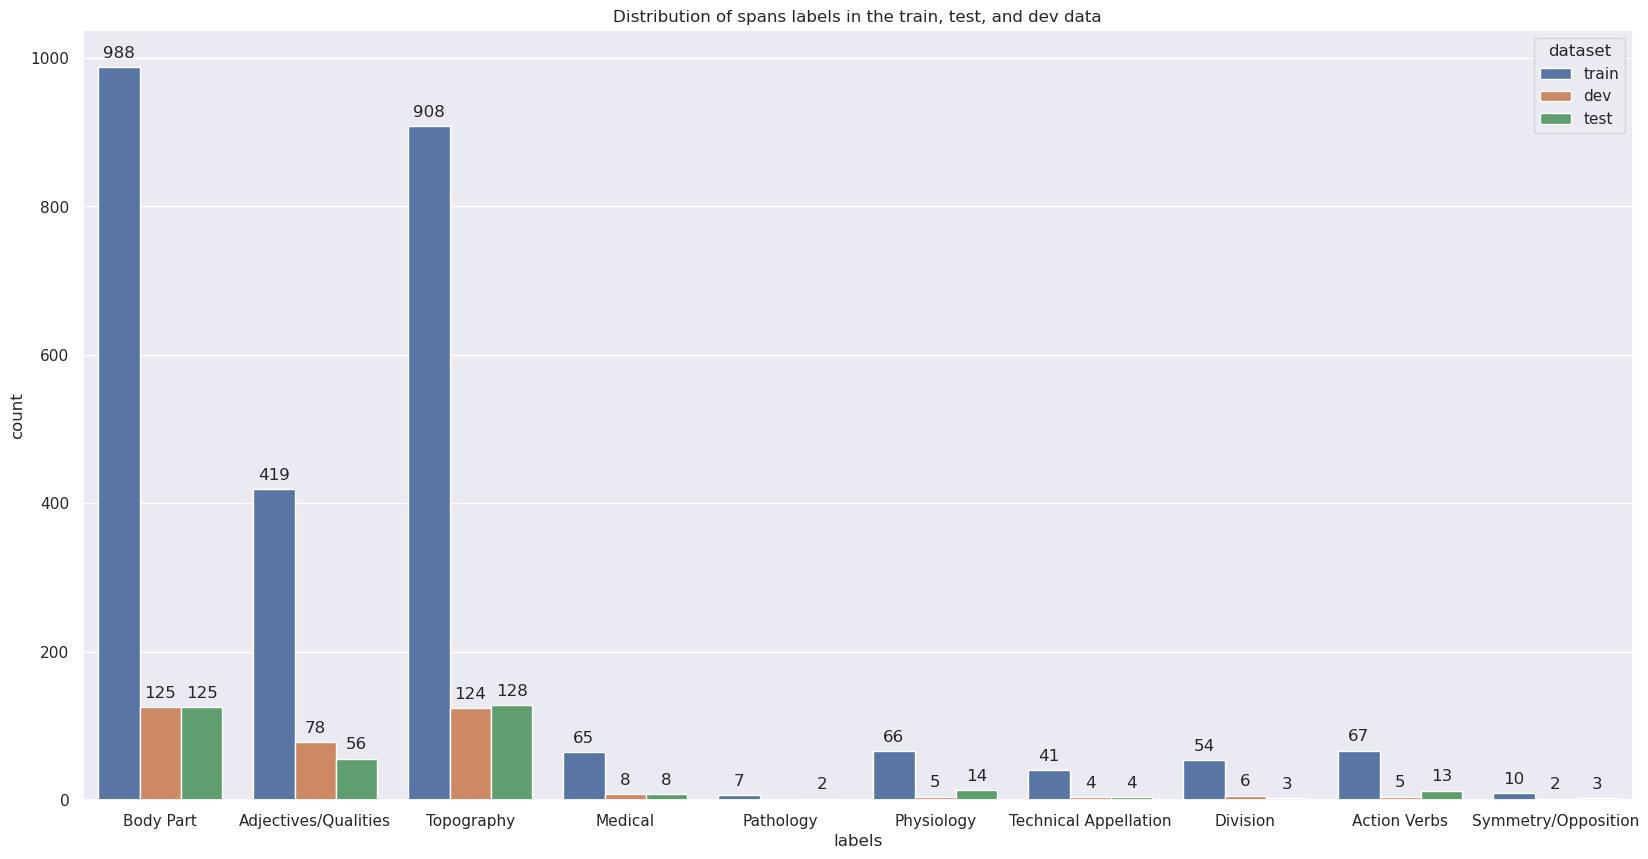

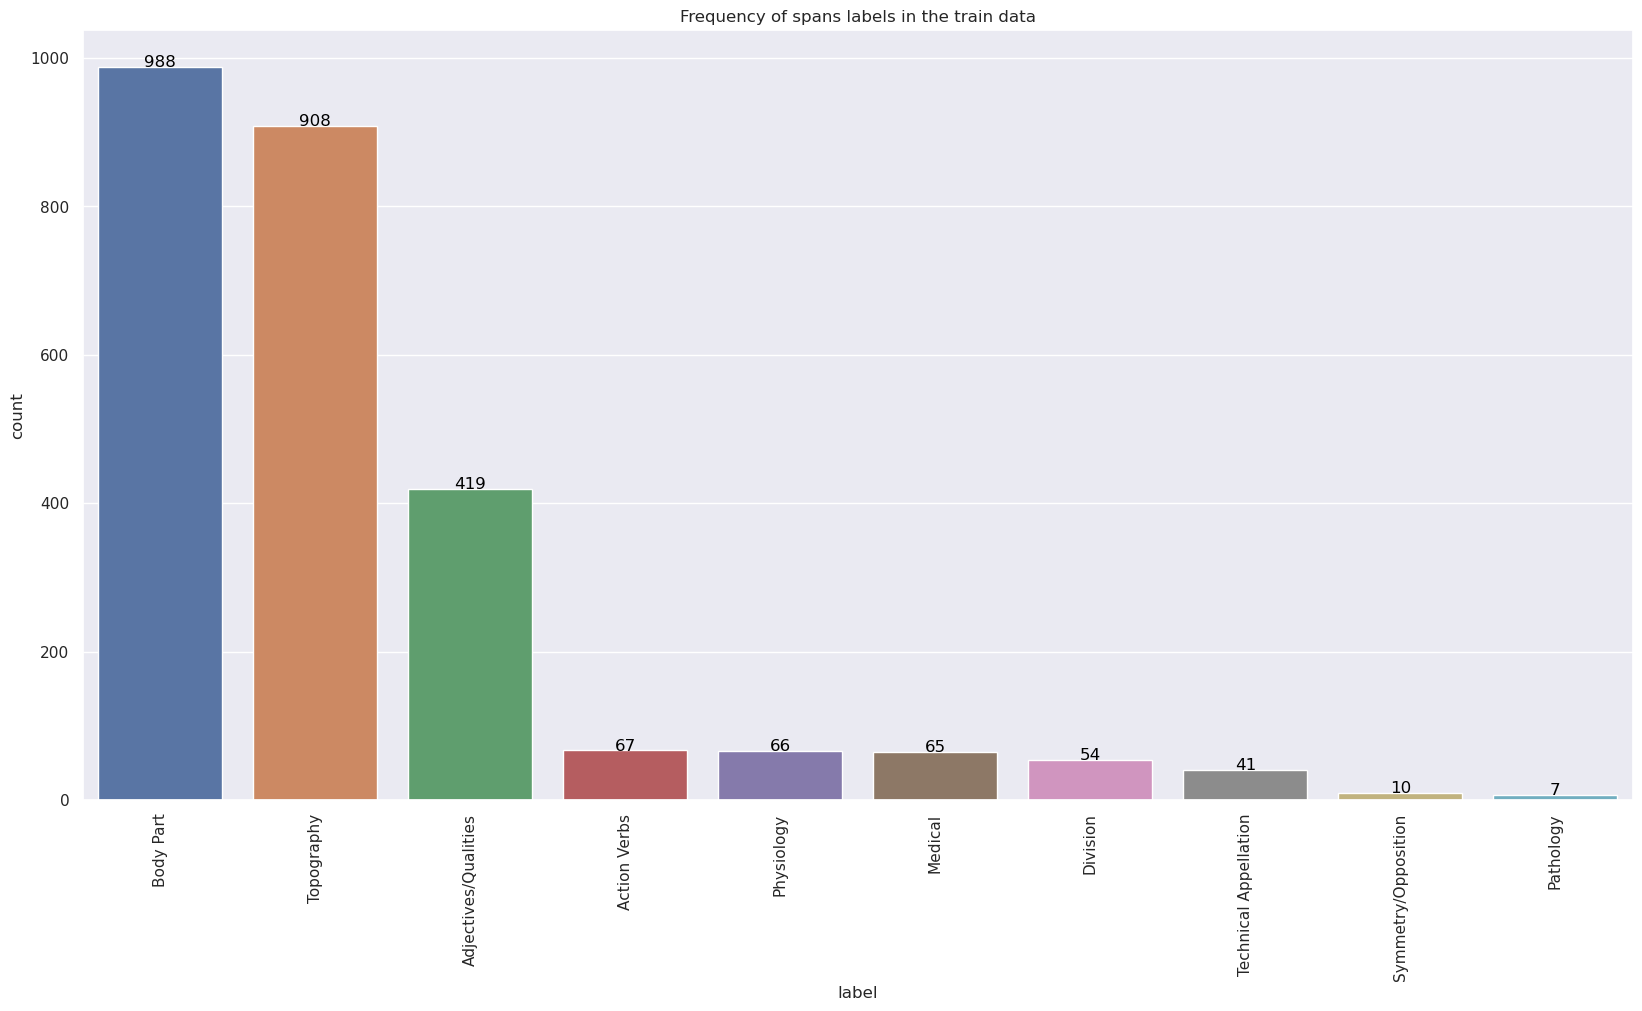

In [35]:
# draw the distribution of ner labels in the train, test and dev data
#train_docs, dev_docs, test_docs = visualize_label_distribution("../training/SageMaker/transformer/PROIEL/Assembled/pos-trf-11-may-2024/model-best/", choice='ents', form='NFKD')

# draw the distribution of spancat labels in the train, test and dev data
train_docs, dev_docs, test_docs = visualize_label_distribution("../training/SageMaker/transformer/PROIEL/Assembled/pos-trf-11-may-2024/model-best/", choice='spans', form='NFKD')

In [ ]:
# load the train, test and dev data
#import spacy
#from spacy.tokens import DocBin
#nlp = spacy.load("grc_proiel_trf")
FORMAT = 'NFKD'
train_docbin = DocBin().from_disk("../corpus/train/ner_train/ner_train_{0}.spacy".format(FORMAT))
# get docs from new_docbin
train_docs = list(train_docbin.get_docs(nlp.vocab))
dev_docbin = DocBin().from_disk("../corpus/dev/ner_dev/ner_dev_{0}.spacy".format(FORMAT))
# get docs from new_docbin
dev_docs = list(dev_docbin.get_docs(nlp.vocab))
test_docbin = DocBin().from_disk("../corpus/test/ner_test/ner_test_{0}.spacy".format(FORMAT))
# get docs from new_docbin
test_docs = list(test_docbin.get_docs(nlp.vocab))
# count sentences in train, test and dev data
print ("train:", len(train_docs), "dev:", len(dev_docs), "test:", len(test_docs))


In [ ]:
import spacy
from spacy.tokens import DocBin
nlp = spacy.load("../training/SageMaker/transformer/PROIEL/Assembled/pos-trf-11-may-2024/model-best/")  # Example with a blank English model. Replace according to your model.
spancat = nlp.add_pipe("spancat")
spancat.cfg["spans_key"] = "sc"

In [39]:
# load the train, test and dev data
#import spacy
from spacy.tokens import DocBin
#nlp = spacy.load("grc_proiel_trf")
FORMAT = 'NFKC'
train_docbin = DocBin().from_disk("../corpus/train/spancat_train/spancat_train_{0}.spacy".format(FORMAT))
# get docs from new_docbin
train_docs = list(train_docbin.get_docs(nlp.vocab))
dev_docbin = DocBin().from_disk("../corpus/dev/spancat_dev/spancat_dev_{0}.spacy".format(FORMAT))
# get docs from new_docbin
dev_docs = list(dev_docbin.get_docs(nlp.vocab))
test_docbin = DocBin().from_disk("../corpus/test/spancat_test/spancat_test_{0}.spacy".format(FORMAT))
# get docs from new_docbin
test_docs = list(test_docbin.get_docs(nlp.vocab))
# count sentences in train, test and dev data
print ("train:", len(train_docs), "dev:", len(dev_docs), "test:", len(test_docs))
# find sentence and print spans
for doc in train_docs:
    # checking a sentenc that had a word with two labels
    #if doc.text == "ἢν δὲ ὀλίγον ᾖ καὶ ἐς ἀμφοτέρας τὰς φλέβας τὸν κατάρροον ποιήσηται ἢ ἐς τὰ ἐπὶ θάτερα, περιγίνονται ἐπίσημα ἐόντα": #NFKD
    #if doc.text == "ἢν δὲ ὀλίγον ᾖ καὶ ἐς ἀμφοτέρας τὰς φλέβας τὸν κατάρροον ποιήσηται ἢ ἐς τὰ ἐπὶ θάτερα, περιγίνονται ἐπίσημα ἐόντα": #NFKC
    #if doc.text == "ἐνίοις μὲν γὰρ εὐρύτερον τὸ πρὸς τῇ κοιλίᾳ, τὸ δὲ πρὸς τῷ τέλει στενώτερον (διόπερ αἱ κύνες μετὰ πόνου προΐενται τὴν τοιαύτην περίττωσιν), τοῖς δὲ πλείοσιν ἄνωθεν στενώτερον, πρὸς τῷ τέλει δʼ εὐρύτερον":
    if doc.text == "φρένες δὲ προσπεφύκασι τῷ ἥπατι ἃς οὐ ῥηΐδιον χωρίσαι. δισσαὶ δὲ ἀπὸ | κληΐδων αἱ μὲν ἔνθεν αἱ δὲ ἔνθεν ὑπὸ στῆθος ἐς ἦτρον·": # nfkc
    #if doc.text == "φρένες δὲ προσπεφύκασι τῷ ἥπατι ἃς οὐ ῥηΐδιον χωρίσαι. δισσαὶ δὲ ἀπὸ | κληΐδων αἱ μὲν ἔνθεν αἱ δὲ ἔνθεν ὑπὸ στῆθος ἐς ἦτρον·": # nfkd
    # chcking a sentence that had a NaN value before
    #if doc.text == "ἡ δʼ ἑτέρη ἄνω τείνει διὰ τῶν φρενῶν καὶ τοῦ πλεύμονος τῶν δεξιῶν, ἀπέσχισται δὲ καὶ ἐς τὴν καρδίην καὶ ἐς τὸν βραχίονα τὸν δεξιόν, καὶ τὸ δὲ λοιπὸν ἄνω φέρει διὰ τῆς κληῗδος ἐς τὰ δεξιὰ τοῦ αὐχένος, ἐς αὐτὸ τὸ δέρμα ὥστε κατάδηλος εἶναι, παρʼ αὐτὸ δὲ τὸ οὖς κρύπτεται καὶ ἐνταῦθα σχίζεται":
        print("doc user data: ", doc.user_data)
        # find spans that have the same token and more than one label
        
        print(doc.text)
        for span in doc.spans["sc"]:
            print(span.text, span.start_char, span.end_char, span.label_)
            # print character text in location of indices of span
            #print(doc.text[span.start_char:span.end_char])      
        # print spansgroup assuming you have a SpanGroup named 'sc' in doc.spans
        span_group = doc.spans["sc"]

        print(f"SpanGroup '{span_group.name}' contains {len(span_group)} spans:")
        for span in span_group:
            print(f"- Span: '{span.text}' [{span.start_char}, {span.end_char}], Labels: {span.label_}")
        for span in doc.spans["sc"]:
            print(type(span.text), span.text, type(span.start_char), span.start_char, type(span.end_char), span.end_char, type(span.label_), span.label_)

train: 412 dev: 53 test: 52
doc user data:  {'source_info': 'Coda, Hippocrates, Sacred Disease, C(8), S(2), P(17), L(5)'}
ἢν δὲ ὀλίγον ᾖ καὶ ἐς ἀμφοτέρας τὰς φλέβας τὸν κατάρροον ποιήσηται ἢ ἐς τὰ ἐπὶ θάτερα, περιγίνονται ἐπίσημα ἐόντα
ἀμφοτέρας 22 31 Adjectives/Qualities
ἀμφοτέρας
ἀμφοτέρας 22 31 Topography
ἀμφοτέρας
φλέβας 36 42 Body Part
φλέβας
θάτερα 79 85 Topography
θάτερα
SpanGroup 'sc' contains 4 spans:
- Span: 'ἀμφοτέρας' [22, 31], Labels: Adjectives/Qualities
- Span: 'ἀμφοτέρας' [22, 31], Labels: Topography
- Span: 'φλέβας' [36, 42], Labels: Body Part
- Span: 'θάτερα' [79, 85], Labels: Topography
<class 'str'> ἀμφοτέρας <class 'int'> 22 <class 'int'> 31 <class 'str'> Adjectives/Qualities
<class 'str'> ἀμφοτέρας <class 'int'> 22 <class 'int'> 31 <class 'str'> Topography
<class 'str'> φλέβας <class 'int'> 36 <class 'int'> 42 <class 'str'> Body Part
<class 'str'> θάτερα <class 'int'> 79 <class 'int'> 85 <class 'str'> Topography


In [32]:
# check pipeline for catspan
nlp.pipe_names
# get spancat component
spancat = nlp.get_pipe("spancat")
# get spancat component config
spancat.cfg
# use spans_key to get spans
spancat.cfg["spans_key"]
from spacy.tokens import Span

Span.set_extension("labels", default=None, force=True)

for doc in train_docs:
    seen_tokens = {}
    for span in doc.spans[spancat.cfg["spans_key"]]:
        if span.root.i not in seen_tokens:
            seen_tokens[span.root.i] = [span.label_]
            #print(f"NOT SEEEEN Token: {doc[span.root.i]}, Labels: {span.label_}")
        else:
            seen_tokens[span.root.i].append(span.label_)
            #print(f"ALREADY SEEN Token: {doc[span.root.i]}, Labels: {span.label_}")
    
    for token_index, labels in seen_tokens.items():
        if len(set(labels)) < len(labels):
            print(f"Token: {doc[token_index]}, Labels: {labels}, {doc.text}")


Token: μεγάλῃ, Labels: ['Technical Appellation', 'Technical Appellation'], συνήρτηται δὲ καὶ τῇ μεγάλῃ φλεβὶ καὶ τῇ ἀορτῇ καλουμένῃ


In [33]:
# debug ner data in spacy
import random
# sample random from train_docs
doc = random.choice(train_docs)
print (doc.text)
for ent in doc.ents:
    print (ent.text, ent.label_)
print ("Spacy entities, for line:")
print (doc.text)
print([(ent.text, ent.label_) for ent in doc.ents])


διότι οὐ δύναται ἐπικρατῆσαι τὸ φλέγμα οὐδ ἀποψῦξαι τὸ αἷμα ὥστε καὶ πῆξαι, ἀλλ αὐτὸ κρατεῖται καὶ καταμίγνυται τῷ αἵματι ταχέως, καὶ οὕτω παραδέχονται αἱ φλέβες τὸν ἠέρα καὶ τὸ φρόνημα ἐγγίνεται
Spacy entities, for line:
διότι οὐ δύναται ἐπικρατῆσαι τὸ φλέγμα οὐδ ἀποψῦξαι τὸ αἷμα ὥστε καὶ πῆξαι, ἀλλ αὐτὸ κρατεῖται καὶ καταμίγνυται τῷ αἵματι ταχέως, καὶ οὕτω παραδέχονται αἱ φλέβες τὸν ἠέρα καὶ τὸ φρόνημα ἐγγίνεται
[]


In [ ]:
from IPython.display import Markdown, display

def print_words_at_indices(sentence, entities, source):
    for start, end, label in entities:
        word = sentence[start:end]
        display(Markdown(sentence[:start] + f"**[{word}]**" + sentence[end:]))
        print(f"Word: {word}, Label: {label}, Source: {source}")

# Example usage:
# Assuming TRAIN_DATA2 is already defined and is not empty.
#sentence, entities_dict = TRAIN_DATA[207]  # Get the first sentence and its entities.
#entities = entities_dict['entities']  # Get the list of entity tuples.
#print_words_at_indices(sentence, entities)
sentence, entities_dict, source = MERGED_TRAIN_DATA[252]  # Get the first sentence and its entities.
entities = entities_dict['entities']  # Get the list of entity tuples.
print_words_at_indices(sentence, entities, source)

In [ ]:
def compare_spans(obj1, obj2):
    """
    Compares the spans of two spaCy objects.
    
    Args:
        obj1 (spacy.tokens.DocBin): The first spaCy object.
        obj2 (spacy.tokens.DocBin): The second spaCy object.
        
    Returns:
        None
    """
    docs1 = list(obj1.get_docs(nlp.vocab))
    docs2 = list(obj2.get_docs(nlp.vocab))
    
    if len(docs1) != len(docs2):
        print(f"Objects have different number of documents: {len(docs1)} vs {len(docs2)}")
        return
    
    for doc1, doc2 in zip(docs1, docs2):
        if doc1.text != doc2.text:
            print(f"Documents have different text:\n{doc1.text}\n{doc2.text}")
            continue
        
        spans1 = list(doc1.spans["sc"])
        spans2 = list(doc2.spans["sc"])
        
        if len(spans1) != len(spans2):
            print(f"Documents have different number of spans: {len(spans1)} vs {len(spans2)}")
            print("Spans in doc1:")
            for span in spans1:
                print(f"- Span: '{span.text}' [{span.start_char}, {span.end_char}], Labels: {span.label_}")
            print("Spans in doc2:")
            for span in spans2:
                print(f"- Span: '{span.text}' [{span.start_char}, {span.end_char}], Labels: {span.label_}")
            continue
        
        for span1, span2 in zip(spans1, spans2):
            if (span1.start_char != span2.start_char or
                span1.end_char != span2.end_char or
                span1.label_ != span2.label_):
                print(f"Document 1 text: {doc1.text}")
                print(f"Document 1 user data: {doc1.user_data}")
                print(f"Document 2 text: {doc2.text}")
                print(f"Document 2 user data: {doc2.user_data}")
                print(f"Span 1: '{span1.text}' [{span1.start_char}, {span1.end_char}], Labels: {span1.label_}")
                #print all the spans in this doc
                for span in spans1:
                    print(f"- Span: '{span.text}' [{span.start_char}, {span.end_char}], Labels: {span.label_}")
                print(f"Span 2: '{span2.text}' [{span2.start_char}, {span2.end_char}], Labels: {span2.label_}")
                 #print all the spans in this doc
                for span in spans2:
                    print(f"- Span: '{span.text}' [{span.start_char}, {span.end_char}], Labels: {span.label_}")



import spacy
from spacy.tokens import DocBin
nlp = spacy.load("../training/SageMaker/transformer/PROIEL/Assembled/pos-trf-11-may-2024/model-best/")  # Example with a blank English model. Replace according to your model.
spancat = nlp.add_pipe("spancat")
spancat.cfg["spans_key"] = "sc"

# Load your spaCy objects
obj1 = DocBin().from_disk("../corpus/train/spancat_train/spancat_old_train_NFKD.spacy")
obj2 = DocBin().from_disk("../corpus/train/spancat_train/spancat_train_NFKD.spacy")

# Compare the spans
compare_spans(obj1, obj2)